<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

**Мягкий дедлайн:** 23:59MSK 19.05.2024

**Жесткий дедлайн:** 23:59MSK 26.05.2024

In [3]:
# !pip install -r requirements.txt

In [1]:
import warnings
import gdown
import pandas as pd
import numpy as np
from copy import deepcopy

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах. Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса.

В качестве инструмента воспользуемся библиотекой ETNA, документацию можно прочитать [тут](https://docs.etna.ai/stable/), и [чат](https://t.me/etna_support) комьюнити.

Мы будем использовать дневные данные реальных банкоматов для чего возьмем мультисегментный датасет.

In [2]:
url = 'https://gist.githubusercontent.com/Polzovat123/4d6d5e544e93429c2d3db29196e9c918/raw/24b27e60f587128d71678e267f51cd48472c6a84/atms_daily_cash.csv'
output = 'atms_daily_cash.csv'
#gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atms_daily_cash.csv', index_col=False)

Полученные данные были просуммированы по банкоматам и дням эксплуатации, после чего залиты в gist, откуда мы и берем их.

Взглянем на то, что представляют из себя данные после этих действий:

In [6]:
df.head()

datetime  atm_id  operation_value
0  2017-08-16      74         2.059266
1  2017-08-17      74         1.029633
2  2017-08-18      74         0.686422
3  2017-08-19      74        33.301267
4  2017-08-20      74       -12.237921

In [7]:
df[abs(df.operation_value) < 0.01]

datetime  atm_id  operation_value
1273  2017-06-21      87     2.220446e-16

### Задание 1. EDA (1.75 балл)

Проведите разведывательный анализ данных с помощью `ETNA`- постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

Ссылку на туториал по EDA можно найти [тут](https://docs.etna.ai/stable/tutorials/103-EDA.html#EDA).

In [5]:
df.atm_id.unique()

array([ 74,  85,  86,  87,  88,  90,  91,  93,  94,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106])

In [3]:
from etna.datasets import TSDataset

In [4]:
df = df.rename(columns={'datetime': 'timestamp', 'atm_id': 'segment', 'operation_value': 'target'})

In [5]:
ts = TSDataset(df, freq="D")
ts.head(120)

segment            100          101         102         103          104  \
feature         target       target      target      target       target   
timestamp                                                                  
2017-06-09         NaN          NaN         NaN         NaN          NaN   
2017-06-10         NaN          NaN         NaN         NaN          NaN   
2017-06-11         NaN          NaN         NaN         NaN          NaN   
2017-06-12         NaN          NaN         NaN         NaN          NaN   
2017-06-13         NaN          NaN         NaN         NaN          NaN   
...                ...          ...         ...         ...          ...   
2017-10-02  130.557440    44.656646  420.796221  -77.281297   -30.182950   
2017-10-03  243.405196    12.502684  141.383294  -16.032854    19.268843   
2017-10-04  -62.366330  1549.732747  288.091260   80.576122    63.631308   
2017-10-05   95.402834    25.064204  119.672751   62.101568  1800.914824   
2017-10-06  263.703672   128.615847  168.712691  173.890273   183.804166   

segment            105         106          74          85          86  \
feature         target      target      target      target      target   
timestamp                                                                
2017-06-09         NaN         NaN         NaN         NaN         NaN   
2017-06-10         NaN         NaN         NaN         NaN         NaN   
2017-06-11         NaN         NaN         NaN         NaN         NaN   
2017-06-12         NaN         NaN         NaN         NaN         NaN   
2017-06-13         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2017-10-02   66.308353   34.948679  510.315439  212.722139    7.707537   
2017-10-03  116.701525  131.086966  529.201847  197.836590    3.383079   
2017-10-04 -258.467254   59.336268   -1.147305  207.662229   82.753060   
2017-10-05  147.325746   19.268843  480.573760  493.488297   55.335409   
2017-10-06  137.264763  -14.679622  383.170496         NaN  116.289671   

segment             87          88          90          91          93  \
feature         target      target      target      target      target   
timestamp                                                                
2017-06-09    0.617780         NaN         NaN         NaN         NaN   
2017-06-10    1.441486         NaN         NaN         NaN         NaN   
2017-06-11   -0.235345         NaN         NaN         NaN         NaN   
2017-06-12  -13.532317         NaN         NaN         NaN         NaN   
2017-06-13    7.398647         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2017-10-02  379.022547 -284.149238 -114.465750  622.545416   62.484003   
2017-10-03   70.162122   76.016320  137.706034  115.201202  205.897144   
2017-10-04 -211.162980  137.735452  159.063560 -161.211080  332.953833   
2017-10-05 -308.036719  127.233197  271.940734   66.249517  147.649345   
2017-10-06  603.011810 -105.816835 -349.457376   77.869659   62.748765   

segment              94          96          97           98          99  
feature          target      target      target       target      target  
timestamp                                                                 
2017-06-09          NaN         NaN         NaN          NaN         NaN  
2017-06-10          NaN         NaN         NaN          NaN         NaN  
2017-06-11          NaN         NaN         NaN          NaN         NaN  
2017-06-12          NaN         NaN         NaN          NaN         NaN  
2017-06-13          NaN         NaN         NaN          NaN         NaN  
...                 ...         ...         ...          ...         ...  
2017-10-02   191.246940  155.239210   50.599098    -3.088898  -99.521366  
2017-10-03    96.844320   -8.796006   49.863646  1997.144778   -0.941379  
2017-10-04  -214.281297  -57.924200 

In [6]:
from etna.transforms import TimeSeriesImputerTransform

In [126]:
ts1 = TSDataset(df, freq="D")
transforms = [TimeSeriesImputerTransform(in_column='target', strategy='constant', constant_value=0).fit(ts1)]
ts1.transform(transforms)

In [10]:
ts1.head(120)

segment            100          101         102         103          104  \
feature         target       target      target      target       target   
timestamp                                                                  
2017-06-09         NaN          NaN         NaN         NaN          NaN   
2017-06-10         NaN          NaN         NaN         NaN          NaN   
2017-06-11         NaN          NaN         NaN         NaN          NaN   
2017-06-12         NaN          NaN         NaN         NaN          NaN   
2017-06-13         NaN          NaN         NaN         NaN          NaN   
...                ...          ...         ...         ...          ...   
2017-10-02  130.557440    44.656646  420.796221  -77.281297   -30.182950   
2017-10-03  243.405196    12.502684  141.383294  -16.032854    19.268843   
2017-10-04  -62.366330  1549.732747  288.091260   80.576122    63.631308   
2017-10-05   95.402834    25.064204  119.672751   62.101568  1800.914824   
2017-10-06  263.703672   128.615847  168.712691  173.890273   183.804166   

segment            105         106          74          85          86  \
feature         target      target      target      target      target   
timestamp                                                                
2017-06-09         NaN         NaN         NaN         NaN         NaN   
2017-06-10         NaN         NaN         NaN         NaN         NaN   
2017-06-11         NaN         NaN         NaN         NaN         NaN   
2017-06-12         NaN         NaN         NaN         NaN         NaN   
2017-06-13         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2017-10-02   66.308353   34.948679  510.315439  212.722139    7.707537   
2017-10-03  116.701525  131.086966  529.201847  197.836590    3.383079   
2017-10-04 -258.467254   59.336268   -1.147305  207.662229   82.753060   
2017-10-05  147.325746   19.268843  480.573760  493.488297   55.335409   
2017-10-06  137.264763  -14.679622  383.170496    0.000000  116.289671   

segment             87          88          90          91          93  \
feature         target      target      target      target      target   
timestamp                                                                
2017-06-09    0.617780         NaN         NaN         NaN         NaN   
2017-06-10    1.441486         NaN         NaN         NaN         NaN   
2017-06-11   -0.235345         NaN         NaN         NaN         NaN   
2017-06-12  -13.532317         NaN         NaN         NaN         NaN   
2017-06-13    7.398647         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2017-10-02  379.022547 -284.149238 -114.465750  622.545416   62.484003   
2017-10-03   70.162122   76.016320  137.706034  115.201202  205.897144   
2017-10-04 -211.162980  137.735452  159.063560 -161.211080  332.953833   
2017-10-05 -308.036719  127.233197  271.940734   66.249517  147.649345   
2017-10-06  603.011810 -105.816835 -349.457376   77.869659   62.748765   

segment              94          96          97           98          99  
feature          target      target      target       target      target  
timestamp                                                                 
2017-06-09          NaN         NaN         NaN          NaN         NaN  
2017-06-10          NaN         NaN         NaN          NaN         NaN  
2017-06-11          NaN         NaN         NaN          NaN         NaN  
2017-06-12          NaN         NaN         NaN          NaN         NaN  
2017-06-13          NaN         NaN         NaN          NaN         NaN  
...                 ...         ...         ...          ...         ...  
2017-10-02   191.246940  155.239210   50.599098    -3.088898  -99.521366  
2017-10-03    96.844320   -8.796006   49.863646  1997.144778   -0.941379  
2017-10-04  -214.281297  -57.924200 

In [11]:
ts.isnull().sum() - ts1.isnull().sum()

segment  feature
100      target     3
101      target     3
102      target     3
103      target     3
104      target     3
105      target     3
106      target     3
74       target     3
85       target     3
86       target     3
87       target     3
88       target     3
90       target     3
91       target     3
93       target     3
94       target     3
96       target     3
97       target     3
98       target     3
99       target     3
dtype: int64

интересное наблюдение - это значит, что TimeSeriesImputerTransform, заполняющий пропуски внутри данных, для каждого сегмента заполнил по 3 значения ровно. Это можно исследовать во втором задании.

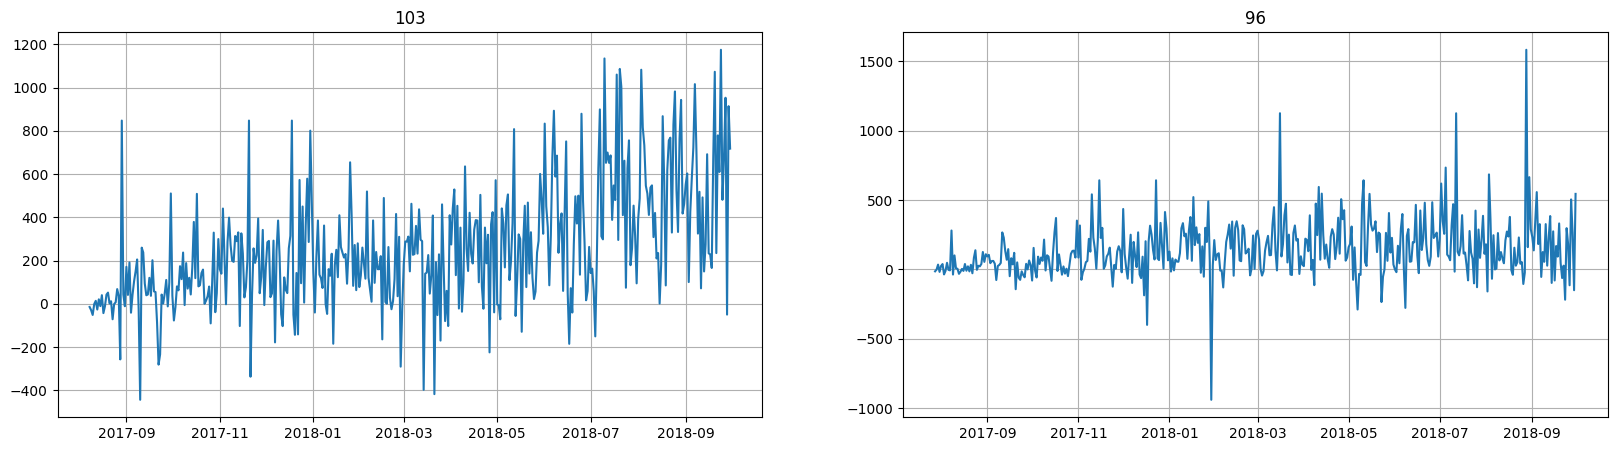

In [22]:
ts1.plot(n_segments=2)

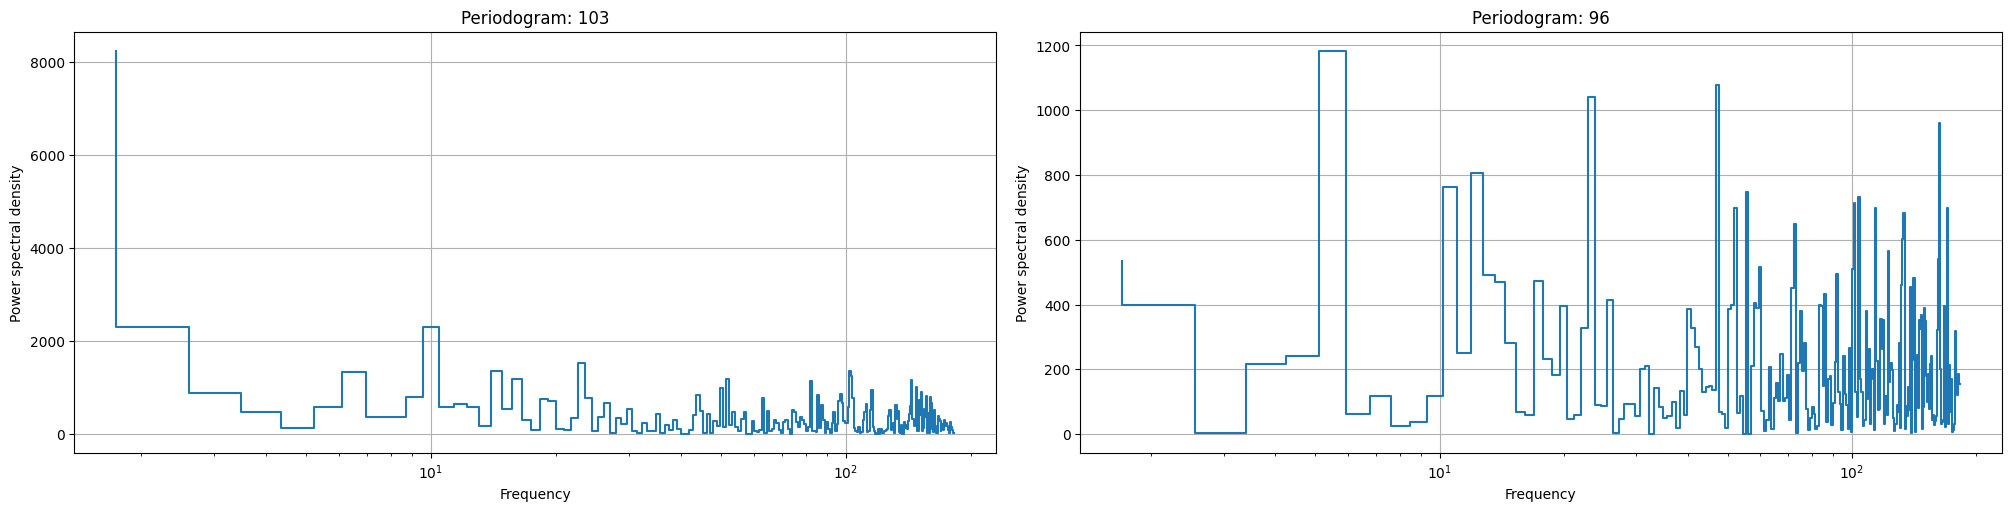

In [26]:
from etna.analysis import plot_periodogram
plot_periodogram(ts1, period=365.2425, amplitude_aggregation_mode="per-segment", segments=['103', '96'])

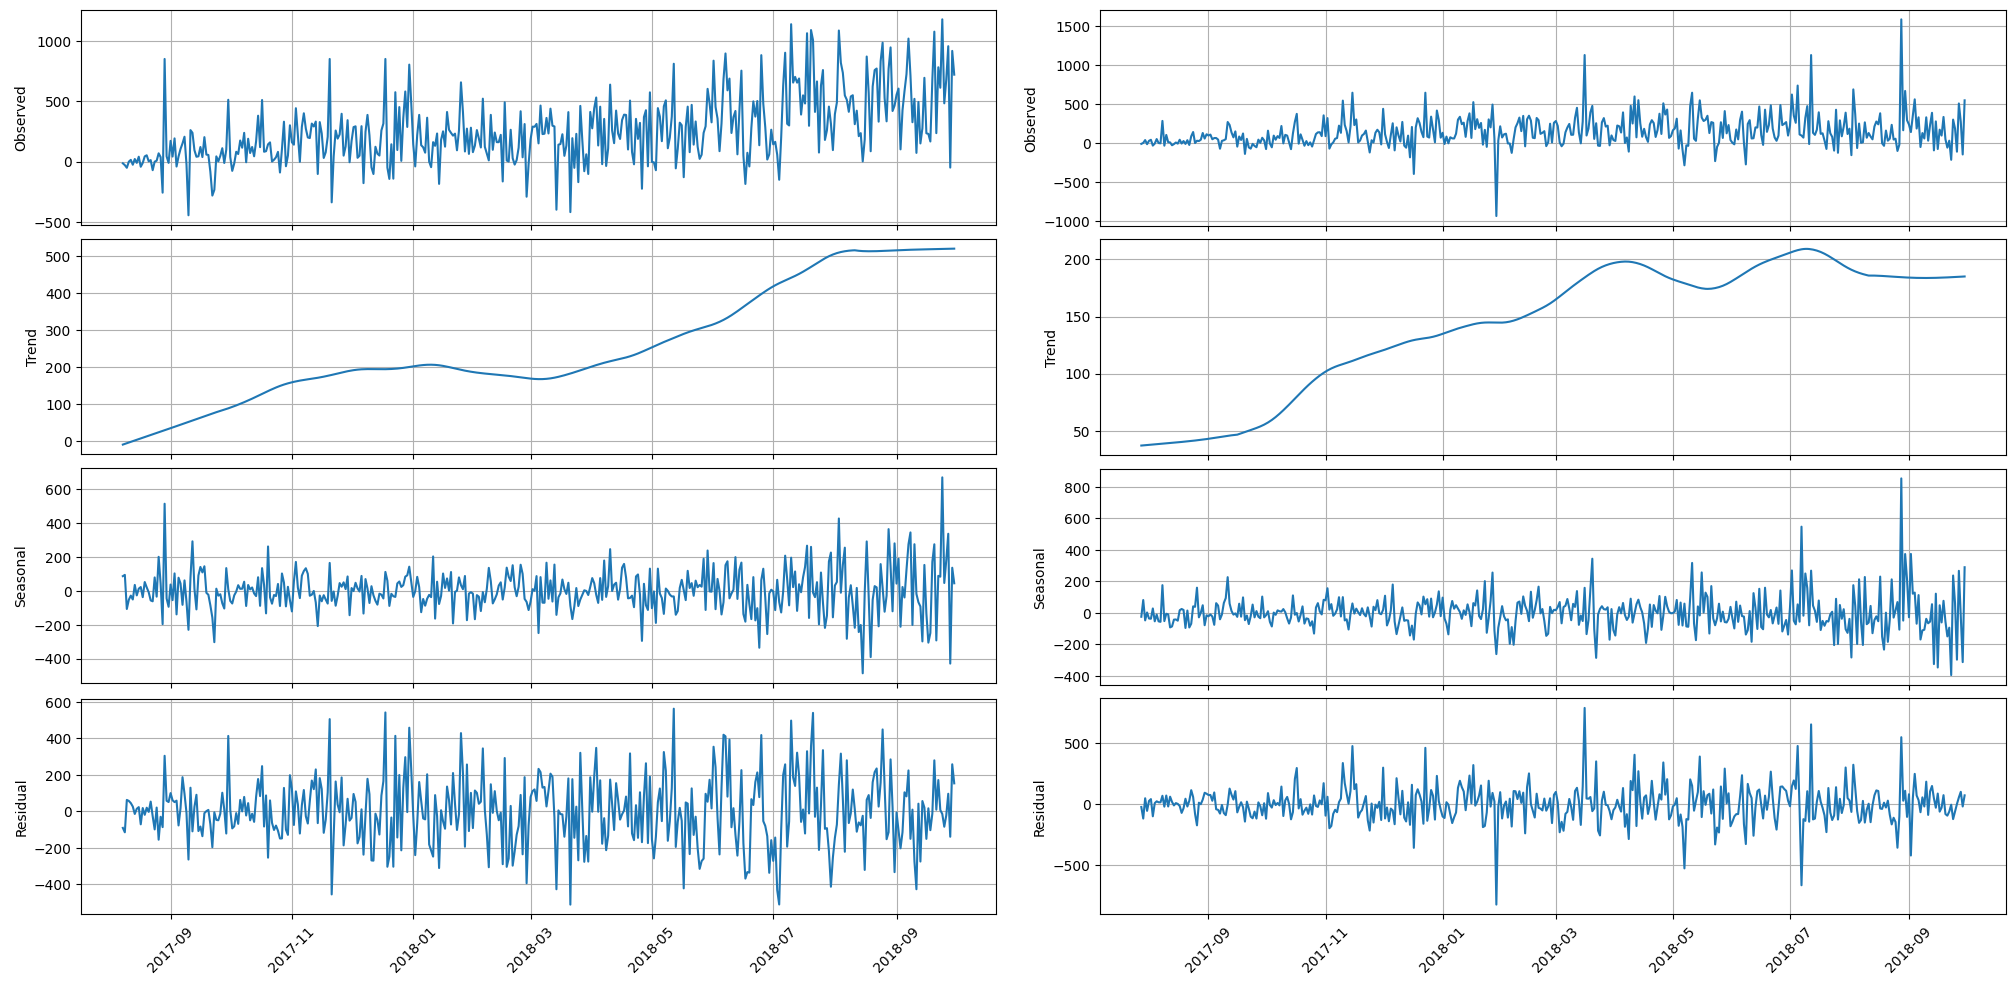

In [27]:
from etna.analysis import stl_plot
stl_plot(ts=ts1, period=52, segments=['103', '96'])

In [127]:
from etna.transforms import LagTransform

lags = [7, 15]
transform = [
    LagTransform(in_column="target", lags=lags, out_column='Lag')
]
ts1.fit_transform(transform)

TypeError: Axis.set_ticks() got an unexpected keyword argument 'labels'

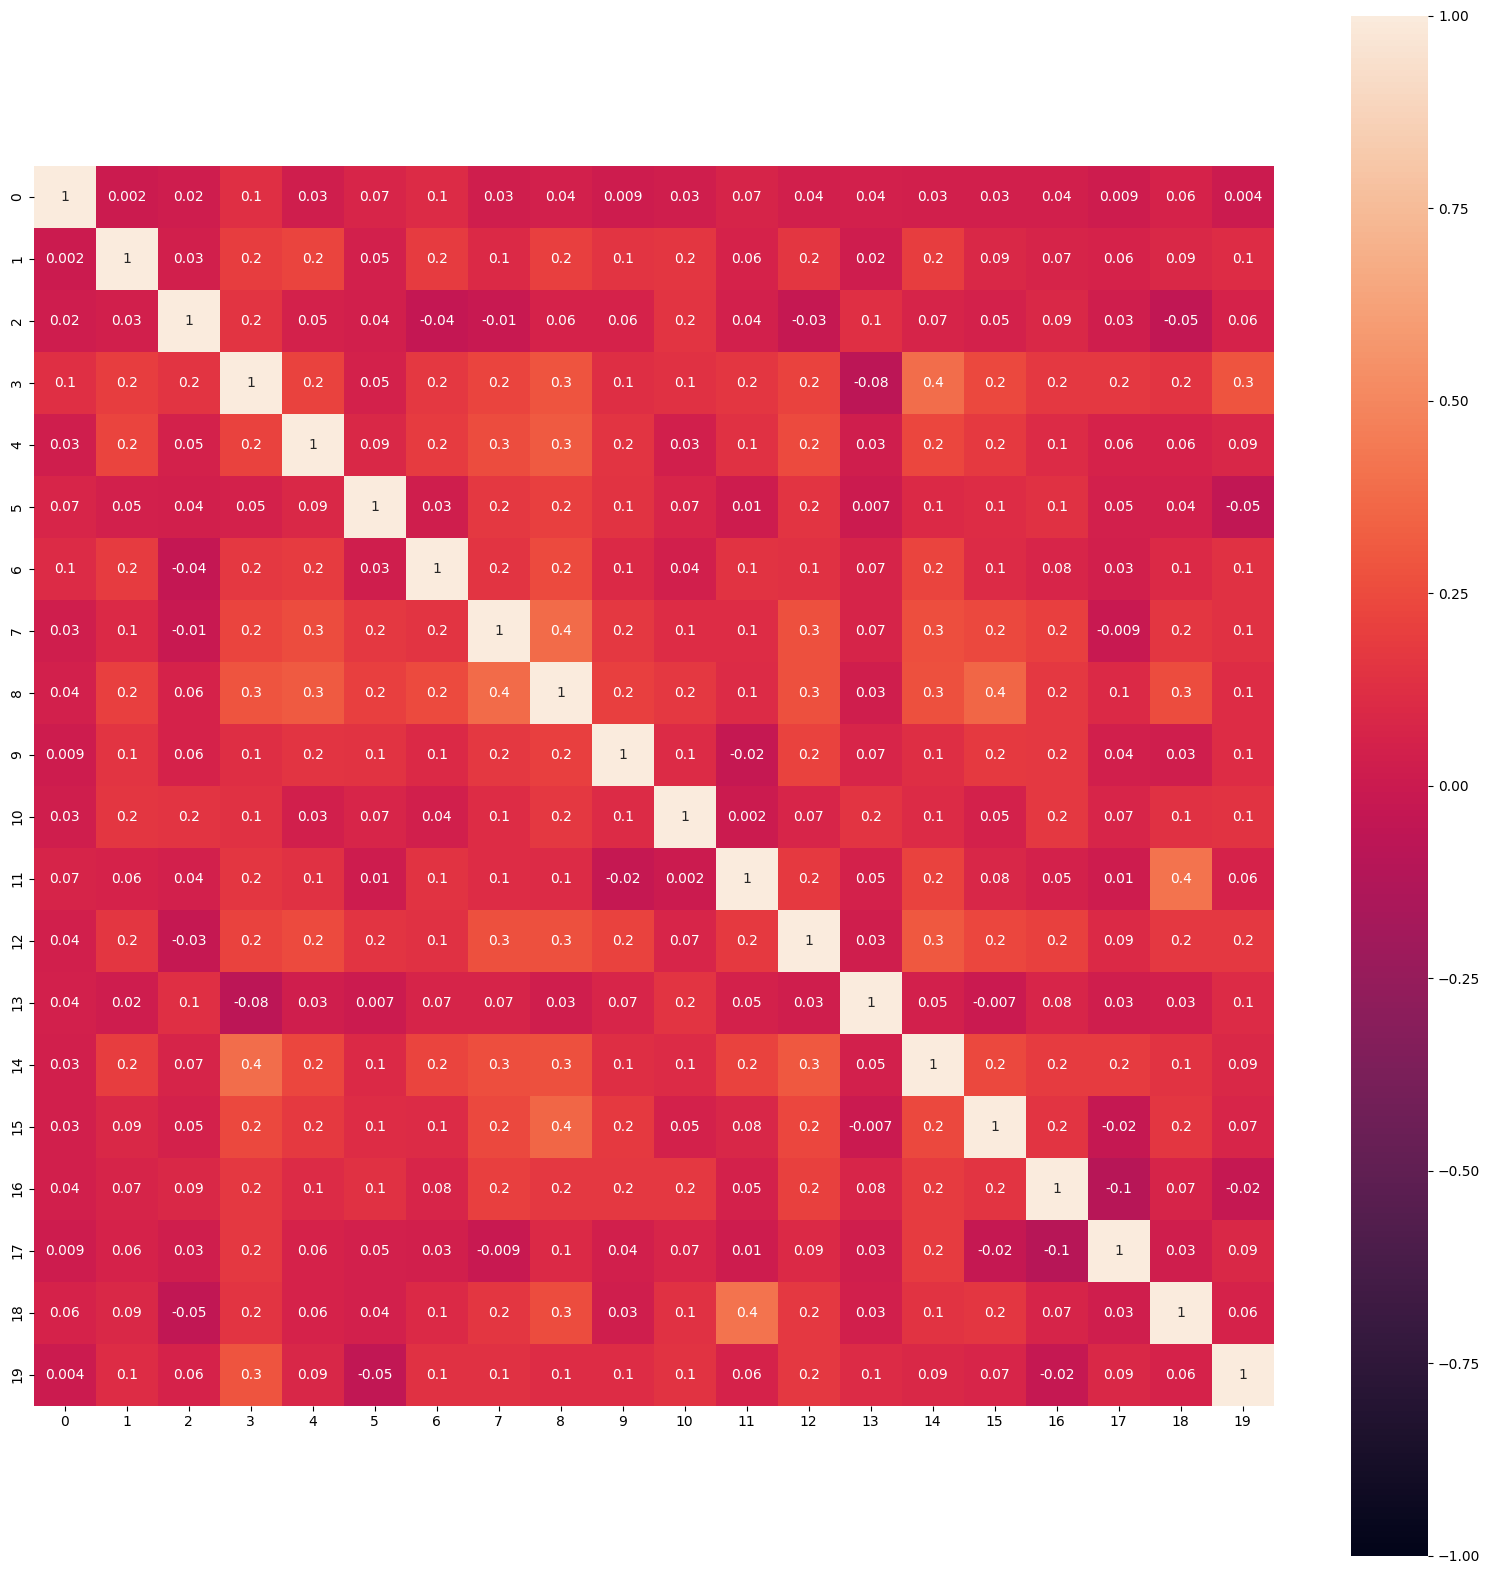

In [138]:
from etna.analysis import plot_correlation_matrix

plot_correlation_matrix(ts, segments=ts.segments, figsize=(20, 20))

высокой корреляции между сегментами нет, некоторые достигают 0.4, но глобальной тенденции нет

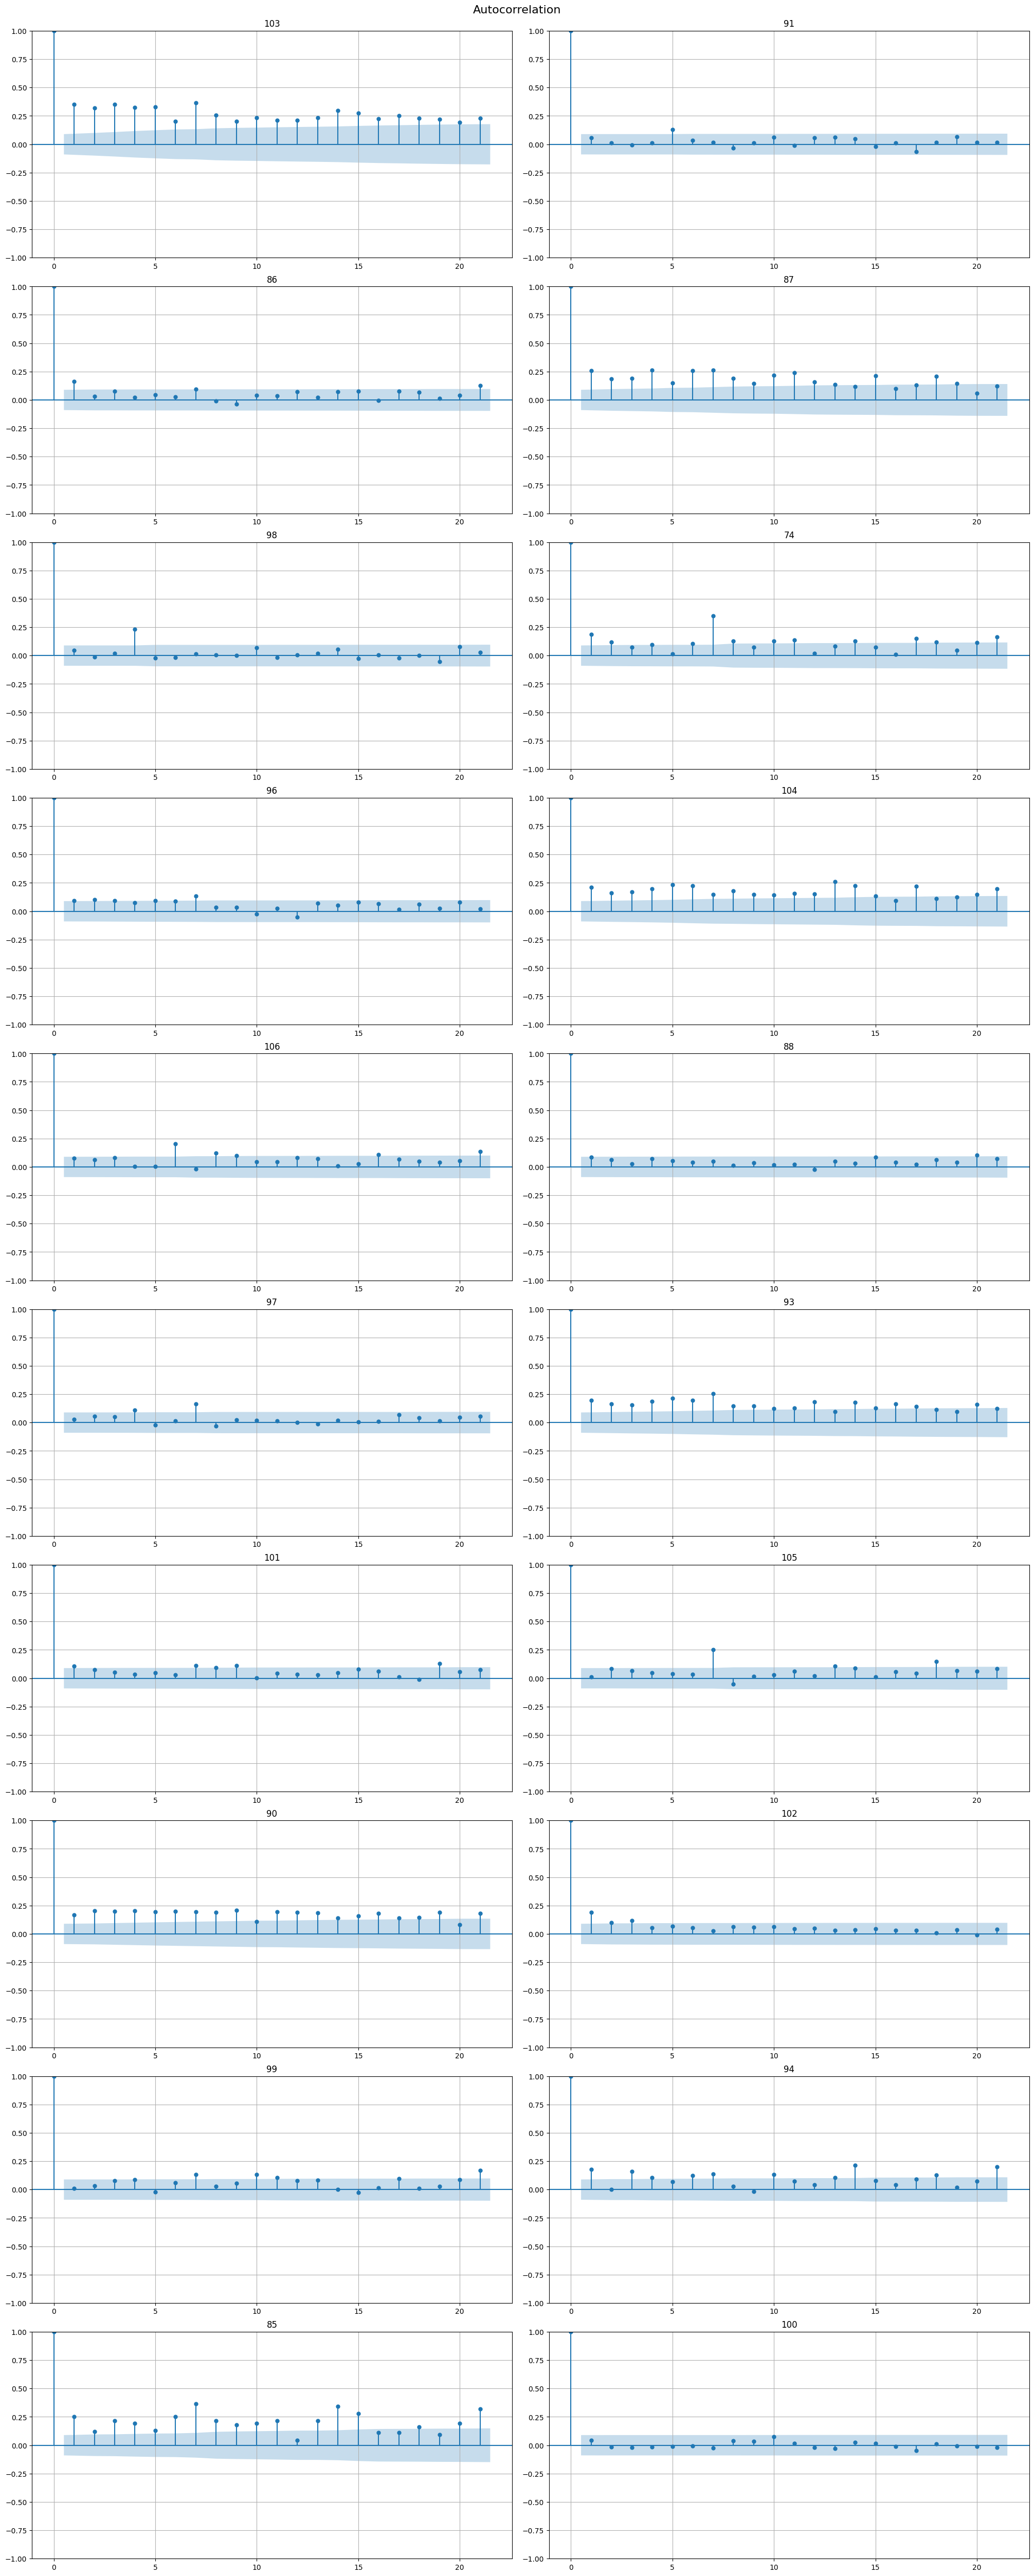

In [139]:
from etna.analysis import acf_plot

acf_plot(ts, lags=21, n_segments=20)

Общей тенденции по автокореляции с каким-то лагом нет. Можно выделить подгруппы, где автокореляция везде маленькая, где на большинстве лагов достигает значений 0.2-0.4, и где есть разовые корреляции на значениях 4-7 

Во всех рядах есть не мало заметный тренд, сезонность не явная, возрастающей/снижающейся со всеменем дисперсии также не наблюдается. Ряды достаточно волатильны.

### Задание 2. Работа с пропущенными значениями и выбросами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

Заполняю скользящим средним с окном 14, так как за это время должен быть ясен кратковременный и долговременный тренды и соблюдены при заполнении данными. Пропусков не много, так что сильного влияния не окажет. Пропуски могут быть связаны например с отключением банкомата на время тех обсуживания, из-за чего отсутствуют данные о нем.

In [8]:
from etna.transforms import TimeSeriesImputerTransform

In [110]:
ts2 = TSDataset(df.rename(columns={'datetime': 'timestamp', 'atm_id': 'segment', 'operation_value': 'target'}), freq="D")
transforms = [TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=14).fit(ts2)]
ts2.transform(transforms)

In [111]:
ts2.head(120)

segment            100          101         102         103          104  \
feature         target       target      target      target       target   
timestamp                                                                  
2017-06-09         NaN          NaN         NaN         NaN          NaN   
2017-06-10         NaN          NaN         NaN         NaN          NaN   
2017-06-11         NaN          NaN         NaN         NaN          NaN   
2017-06-12         NaN          NaN         NaN         NaN          NaN   
2017-06-13         NaN          NaN         NaN         NaN          NaN   
...                ...          ...         ...         ...          ...   
2017-10-02  130.557440    44.656646  420.796221  -77.281297   -30.182950   
2017-10-03  243.405196    12.502684  141.383294  -16.032854    19.268843   
2017-10-04  -62.366330  1549.732747  288.091260   80.576122    63.631308   
2017-10-05   95.402834    25.064204  119.672751   62.101568  1800.914824   
2017-10-06  263.703672   128.615847  168.712691  173.890273   183.804166   

segment            105         106          74          85          86  \
feature         target      target      target      target      target   
timestamp                                                                
2017-06-09         NaN         NaN         NaN         NaN         NaN   
2017-06-10         NaN         NaN         NaN         NaN         NaN   
2017-06-11         NaN         NaN         NaN         NaN         NaN   
2017-06-12         NaN         NaN         NaN         NaN         NaN   
2017-06-13         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2017-10-02   66.308353   34.948679  510.315439  212.722139    7.707537   
2017-10-03  116.701525  131.086966  529.201847  197.836590    3.383079   
2017-10-04 -258.467254   59.336268   -1.147305  207.662229   82.753060   
2017-10-05  147.325746   19.268843  480.573760  493.488297   55.335409   
2017-10-06  137.264763  -14.679622  383.170496  162.955152  116.289671   

segment             87          88          90          91          93  \
feature         target      target      target      target      target   
timestamp                                                                
2017-06-09    0.617780         NaN         NaN         NaN         NaN   
2017-06-10    1.441486         NaN         NaN         NaN         NaN   
2017-06-11   -0.235345         NaN         NaN         NaN         NaN   
2017-06-12  -13.532317         NaN         NaN         NaN         NaN   
2017-06-13    7.398647         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2017-10-02  379.022547 -284.149238 -114.465750  622.545416   62.484003   
2017-10-03   70.162122   76.016320  137.706034  115.201202  205.897144   
2017-10-04 -211.162980  137.735452  159.063560 -161.211080  332.953833   
2017-10-05 -308.036719  127.233197  271.940734   66.249517  147.649345   
2017-10-06  603.011810 -105.816835 -349.457376   77.869659   62.748765   

segment              94          96          97           98          99  
feature          target      target      target       target      target  
timestamp                                                                 
2017-06-09          NaN         NaN         NaN          NaN         NaN  
2017-06-10          NaN         NaN         NaN          NaN         NaN  
2017-06-11          NaN         NaN         NaN          NaN         NaN  
2017-06-12          NaN         NaN         NaN          NaN         NaN  
2017-06-13          NaN         NaN         NaN          NaN         NaN  
...                 ...         ...         ...          ...         ...  
2017-10-02   191.246940  155.239210   50.599098    -3.088898  -99.521366  
2017-10-03    96.844320   -8.796006   49.863646  1997.144778   -0.941379  
2017-10-04  -214.281297  -57.924200 

Проверьте ряды на наличие выбросов, и очистите их соответствующим образом. Обоснуйте выбор.

Возьмем достоточно щадящий базовый параметр альфа для определения выбросов (те выбросы, что больше похожи на структуру данных, оставляем)

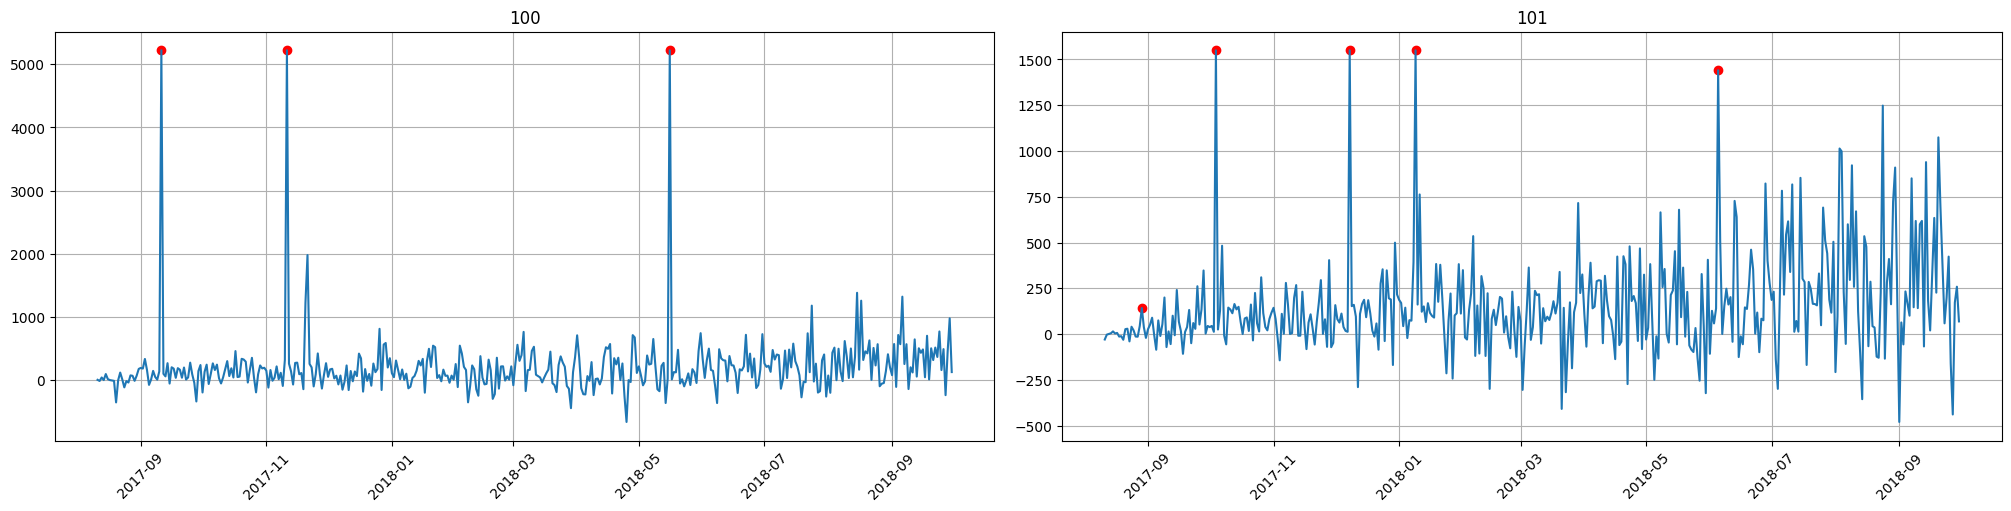

In [112]:
from etna.analysis.outliers.median_outliers import get_anomalies_median
from etna.analysis.outliers.plots import plot_anomalies

anomalies_median = get_anomalies_median(ts=ts2, in_column='target', window_size=14)
plot_anomalies(ts2, anomalies_median, segments=['100', '101'])

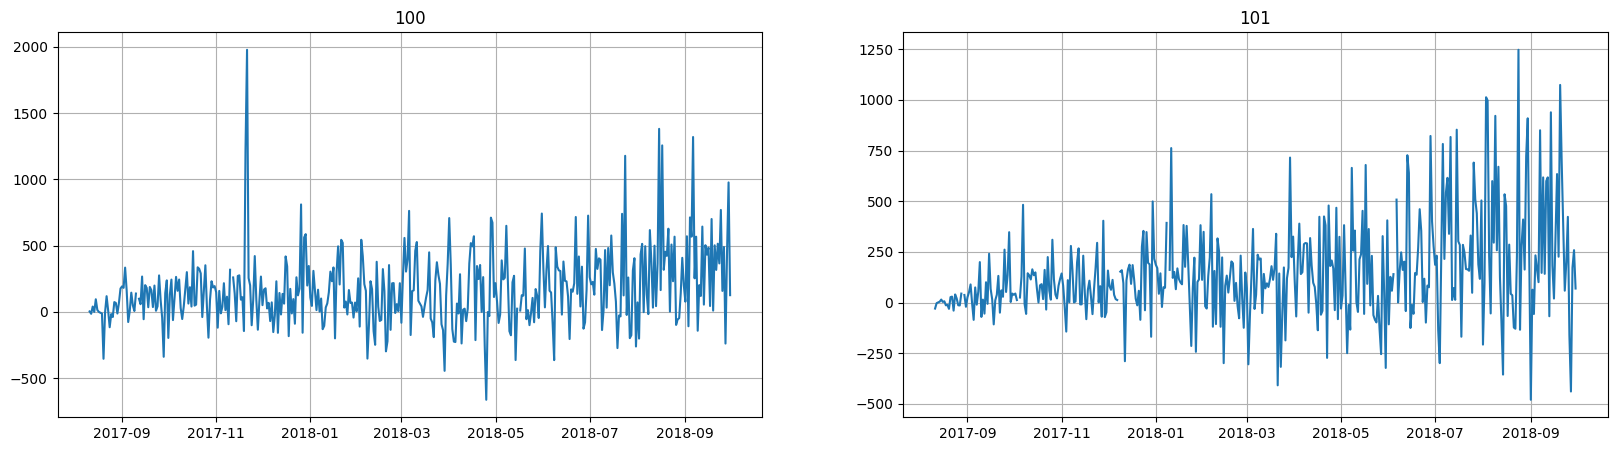

In [107]:
from etna.transforms import MedianOutliersTransform

transforms = [MedianOutliersTransform(in_column="target", window_size=14)]
ts2.fit_transform(transforms)
ts2.plot(segments=['100', '101'])

### Задание 3. Построение Prophet (1.25 балла)

Постройте прогнозы с помощью Prophet и `etna.Pipeline`, под капотом `etna.Pipeline` обучит `ProphetModel` для каждого сегмента в отдельности. После этого оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [9]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [10]:
HORIZON = 5

In [ ]:
model = ProphetModel(daily_seasonality=True, yearly_seasonality=True)

# Создаем пайплайн с горизонтом предсказания 5 дней
pipeline = Pipeline(model=model, horizon=HORIZON)

# Оценка качества модели с помощью кросс-валидации
metrics = [SMAPE(), MAE()]

n_folds = 70  # количество фолдов для кросс-валидации

metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts1, metrics=metrics, n_folds=n_folds, n_jobs=2)

Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7wap27b7/fjchxne9.json
22:27:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7wap27b7/ovvku2p9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7wap27b7/bqyfnfoi.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4321', 'data', 'file=/tmp/tmp7wap27b7/fjchxne9.json', 'init=/tmp/tmp7wap27b7/ovvku2p9.json', 'output', 'file=/tmp/tmp7wap27b7/prophet_model025oe9tx/prophet_model-20240518222702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:27:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:27:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done p

In [ ]:
fold_info_df

train_start_time train_end_time test_start_time test_end_time  fold_number
0        2017-06-09     2017-10-15      2017-10-16    2017-10-20            0
1        2017-06-09     2017-10-20      2017-10-21    2017-10-25            1
2        2017-06-09     2017-10-25      2017-10-26    2017-10-30            2
3        2017-06-09     2017-10-30      2017-10-31    2017-11-04            3
4        2017-06-09     2017-11-04      2017-11-05    2017-11-09            4
..              ...            ...             ...           ...          ...
65       2017-06-09     2018-09-05      2018-09-06    2018-09-10           65
66       2017-06-09     2018-09-10      2018-09-11    2018-09-15           66
67       2017-06-09     2018-09-15      2018-09-16    2018-09-20           67
68       2017-06-09     2018-09-20      2018-09-21    2018-09-25           68
69       2017-06-09     2018-09-25      2018-09-26    2018-09-30           69

[70 rows x 5 columns]

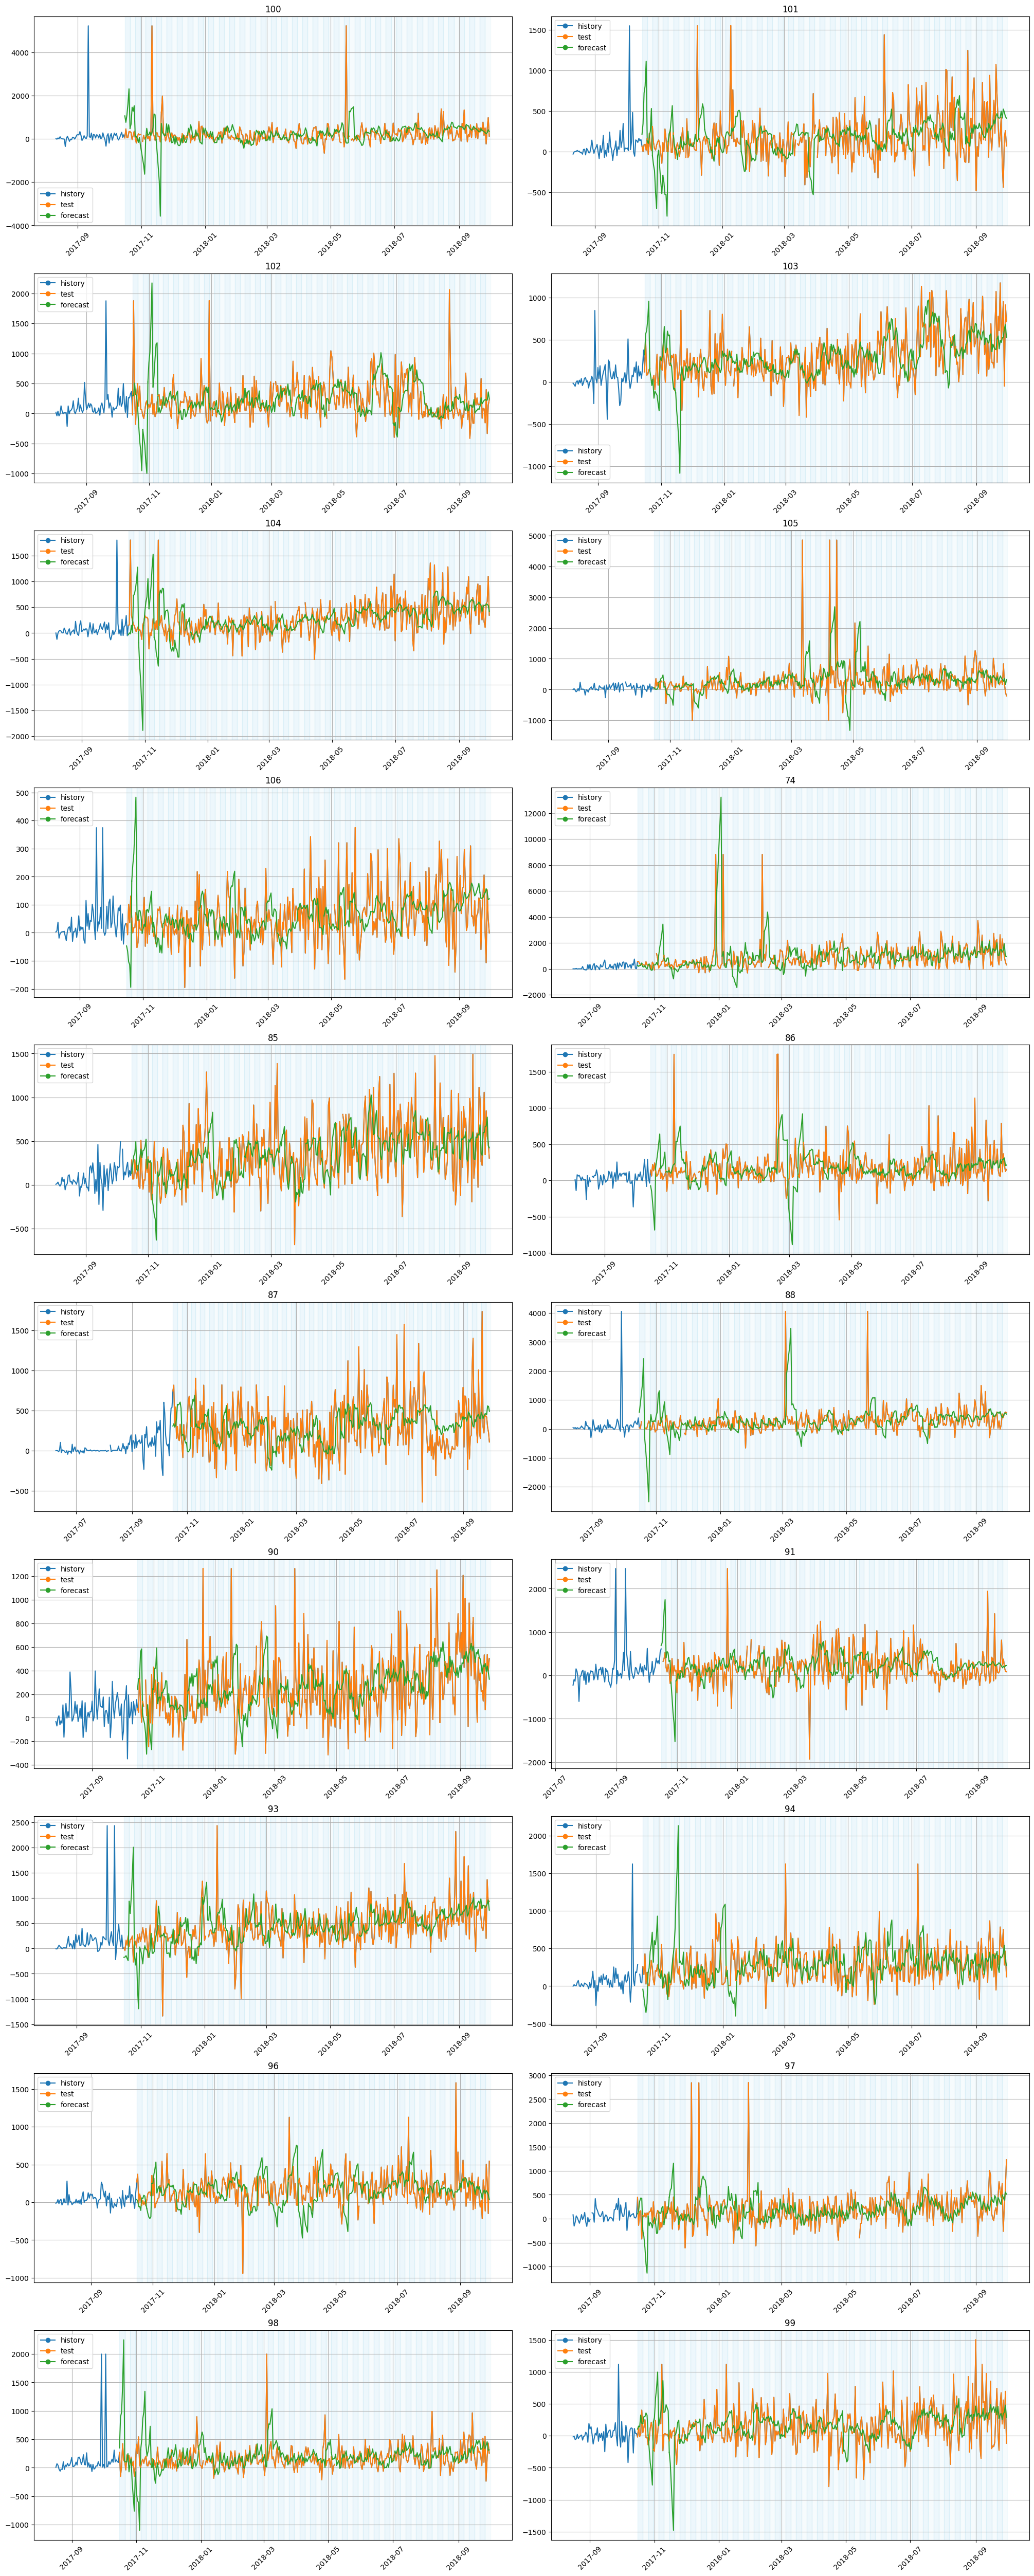

In [ ]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len='all')

In [ ]:
metrics_mean_segment = metrics_df.groupby('segment')[['SMAPE', 'MAE']].mean()
metrics_mean_segment.sort_values(by='SMAPE')

SMAPE         MAE
segment                        
85        44.124840  221.068660
93        44.360659  248.477567
104       47.055497  229.835072
86        49.445262  127.911593
90        51.786705  157.745957
87        55.924469  252.851808
94        57.627476  199.289426
74        59.823840  682.114737
88        62.030090  176.199364
103       64.276651  324.069005
98        79.121088  179.357168
102       80.045330  164.711736
101       83.592485  255.678333
100       85.031908  261.950413
105       85.110993  290.233446
106       88.711018   67.144152
91        89.839678  252.344579
97        89.911917  281.484570
96       114.745741  212.676437
99       123.727137  304.834701

In [ ]:
metrics_mean_segment = metrics_df.groupby('segment')[['SMAPE', 'MAE']].mean()
metrics_mean_segment.sort_values(by='SMAPE')
# вывод после обучения на 70 фолдах

SMAPE         MAE
segment                        
93        85.607019  340.517841
103       86.931731  229.580228
85        87.529800  272.802464
74        88.036331  795.085313
94        88.903517  236.678758
104       97.492397  288.098822
90        98.201308  238.491277
98       100.961131  206.894211
87       101.037956  284.287048
86       108.103655  216.176430
105      109.109513  385.720933
88       112.524100  366.302184
96       114.955236  209.815419
102      116.894985  282.243028
97       119.760383  284.794203
91       120.901881  334.923241
101      124.366409  266.219353
106      124.553504   88.143945
100      124.861645  379.619744
99       126.660497  276.503464

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

Профет хорошая модель, но ее результат больше похоже на скользящее среднее с незначительными отклонениями, чего недостаточно для прогнозирования таких валотильных рядов. Хотя и стратегия среднего дает довольно неплохое значение метрик.

### Задание 4. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/etna-team/etna/blob/master/examples/303-hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [11]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import TopDownReconciliator

In [17]:
ts.segments

['100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '74',
 '85',
 '86',
 '87',
 '88',
 '90',
 '91',
 '93',
 '94',
 '96',
 '97',
 '98',
 '99']

In [18]:
df.target.max()

8814.910299704034

In [19]:
df1 = df.copy()
df1.target = df.target + 2000
df1.target.min()

74.7043160833

In [20]:
levels = {
    "total": ts.segments
}
hierarchical_structure = HierarchicalStructure(level_structure=levels, level_names=["total", "atm"])
hierarchical_ts = TSDataset(df=df1, freq="D", hierarchical_structure=hierarchical_structure)
hierarchical_ts.tail(5)

segment             100          101          102          103          104  \
feature          target       target       target       target       target   
timestamp                                                                     
2018-09-26  2489.428602  1838.553575  1848.349796  2677.704316  2114.818767   
2018-09-27  1760.507408  1561.199914  2398.467898  2953.351729  2568.916255   
2018-09-28  2447.007730  2172.448787  1667.575693  1949.989263  2606.659652   
2018-09-29  2976.797939  2258.761434  2140.942023  2914.431608  3097.500322   
2018-09-30  2125.791711  2069.338415  2231.490874  2718.065922  2345.633026   

segment             105          106           74           85           86  \
feature          target       target       target       target       target   
timestamp                                                                     
2018-09-26  2160.505046  2002.794718  4297.228473  2348.074726  2120.378785   
2018-09-27  2836.297187  1893.212368  3693.304703  2846.975950  2367.520077   
2018-09-28  2178.891346  2153.091690  2937.613056  2557.207859  2209.133133   
2018-09-29  1917.011595  2049.775392  2553.560017  2489.163839  2123.820700   
2018-09-30  1791.484647  1999.705819  2300.917543  2306.448143  2150.532317   

segment              87           88           90           91           93  \
feature          target       target       target       target       target   
timestamp                                                                     
2018-09-26  2430.162938  2511.345072  2069.338415  2243.022761  2844.916685   
2018-09-27  2420.081361  2382.935151  2351.575478  2374.727507  2199.748765   
2018-09-28  2293.298261  2530.084389  2536.821129  2179.420872  3364.028130   
2018-09-29  2231.049603  2580.889414  2395.908525  2093.372987  2916.108439   
2018-09-30  2108.611553  2560.414430  2501.695942  2084.312218  2935.583208   

segment              94           96           97           98           99  
feature          target       target       target       target       target  
timestamp                                                                    
2018-09-26  2517.022761  1885.916685  2739.570539  2547.176294  2187.216663  
2018-09-27  2753.397037  2504.549495  1735.649130  1764.390595  2560.208503  
2018-09-28  2280.413142  2265.998282  2250.818553  2180.862358  2116.142581  
2018-09-29  2463.364183  1850.261971  2606.012454  2433.651922  2696.149452  
2018-09-30  2123.644192  2544.499248  3232.882328  2255.643118  1883.622074

In [21]:
hierarchical_ts.get_level_dataset(target_level="total").tail(5)

segment            total
feature           target
timestamp               
2018-09-26  47873.525617
2018-09-27  47927.016513
2018-09-28  46877.505905
2018-09-29  48788.533820
2018-09-30  46270.316728

In [117]:
reconciliator = TopDownReconciliator(target_level="atm", source_level="total", method="AHP", period=5)

pipeline = HierarchicalPipeline(
    model=ProphetModel(),
    reconciliator=reconciliator,
    horizon=HORIZON
)

metrics = [MAE()]

ahp_metrics, ahp_forecast, _ = pipeline.backtest(ts=hierarchical_ts, metrics=metrics, n_folds=5, aggregate_metrics=True)

04:14:07 - cmdstanpy - INFO - Chain [1] start processing
04:14:07 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
04:14:07 - cmdstanpy - INFO - Chain [1] start processing
04:14:07 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
04:14:07 - cmdstanpy - INFO - Chain [1] start processing
04:14:07 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
04:14:07 - cmdstanpy - INFO - Chain [1] start processing
04:14:07 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.4s
04:14:08 - cmdstanpy - INFO - Chain [1] start processing
04:14:08 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Paralle

In [23]:
pipeline1 = Pipeline(model=ProphetModel(daily_seasonality=True, yearly_seasonality=True), horizon=HORIZON)

metrics_df1, forecast_df1, fold_info_df1 = pipeline1.backtest(ts, metrics=metrics, n_folds=5, aggregate_metrics=True)

19:16:23 - cmdstanpy - INFO - Chain [1] start processing
19:16:23 - cmdstanpy - INFO - Chain [1] done processing
19:16:23 - cmdstanpy - INFO - Chain [1] start processing
19:16:23 - cmdstanpy - INFO - Chain [1] done processing
19:16:23 - cmdstanpy - INFO - Chain [1] start processing
19:16:23 - cmdstanpy - INFO - Chain [1] done processing
19:16:24 - cmdstanpy - INFO - Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1] done processing
19:16:24 - cmdstanpy - INFO - Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1] done processing
19:16:24 - cmdstanpy - INFO - Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1] done processing
19:16:24 - cmdstanpy - INFO - Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1] done processing
19:16:24 - cmdstanpy - INFO - Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1] done processing
19:16:24 - cmdstanpy - INFO - Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1]

In [25]:
ahp_metrics = ahp_metrics.set_index("segment").add_suffix("_ahp")
metrics_mean = metrics_df1.set_index("segment").add_suffix("_atm_level")

In [26]:
all_metrics = pd.concat([ahp_metrics, metrics_mean], axis=1)
all_metrics

MAE_ahp  MAE_atm_level
segment                           
100      272.607997     285.911349
101      315.727960     309.135288
102      305.109312     226.543800
103      283.490997     267.398657
104      287.196083     250.512477
105      295.137328     277.918351
106       69.737640      91.443786
74       768.951230     598.989726
85       323.883071     266.777040
86       190.572418     172.814477
87       457.364005     336.371277
88       413.892846     334.596857
90       205.291491     210.418686
91       332.660638     310.275370
93       331.348148     347.576921
94       196.433847     190.592950
96       182.638740     175.624062
97       359.059973     280.343662
98       228.150723     238.778289
99       376.494457     338.958425

In [27]:
all_metrics.mean()

MAE_ahp          309.787445
MAE_atm_level    275.549072
dtype: float64

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от выбросов уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [116]:
reconciliator = TopDownReconciliator(target_level="atm", source_level="total", method="AHP", period=5)

pipeline = HierarchicalPipeline(
    model=ProphetModel(),
    reconciliator=reconciliator,
    transforms=[
        TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=14),
        MedianOutliersTransform(in_column="target", window_size=14)
    ],
    horizon=HORIZON
)

metrics = [MAE()]

ahp_metrics1, ahp_forecast1, _ = pipeline.backtest(ts=hierarchical_ts, metrics=metrics, n_folds=5, aggregate_metrics=True)

04:13:55 - cmdstanpy - INFO - Chain [1] start processing
04:13:55 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
04:13:55 - cmdstanpy - INFO - Chain [1] start processing
04:13:55 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
04:13:55 - cmdstanpy - INFO - Chain [1] start processing
04:13:55 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
04:13:55 - cmdstanpy - INFO - Chain [1] start processing
04:13:56 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.6s
04:13:56 - cmdstanpy - INFO - Chain [1] start processing
04:13:56 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Paralle

### Задание 5. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества.

Из обязательного:
1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков
2) для катбуста включите в признаки результаты STL разложения. STL используем для убирания тренда за счет преобразования на месте.
* Кроме этого, подумайте на экспертном уровне,
    - Какие еще закономерности могут присутствовать и почему?
    - Что из этого кажется более предсказуемым, и почему?
    - Cделайте соответствующие признаки, и снабдите их кратким комментарием.

3) После этого, обучите на получившихся признаках модели. Для `CatBoost` рассмотрите 2 версии мультисегментную и на каждый ряд в отдельности.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [12]:
from etna.analysis import acf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostPerSegmentModel,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform, DateFlagsTransform, HolidayTransform

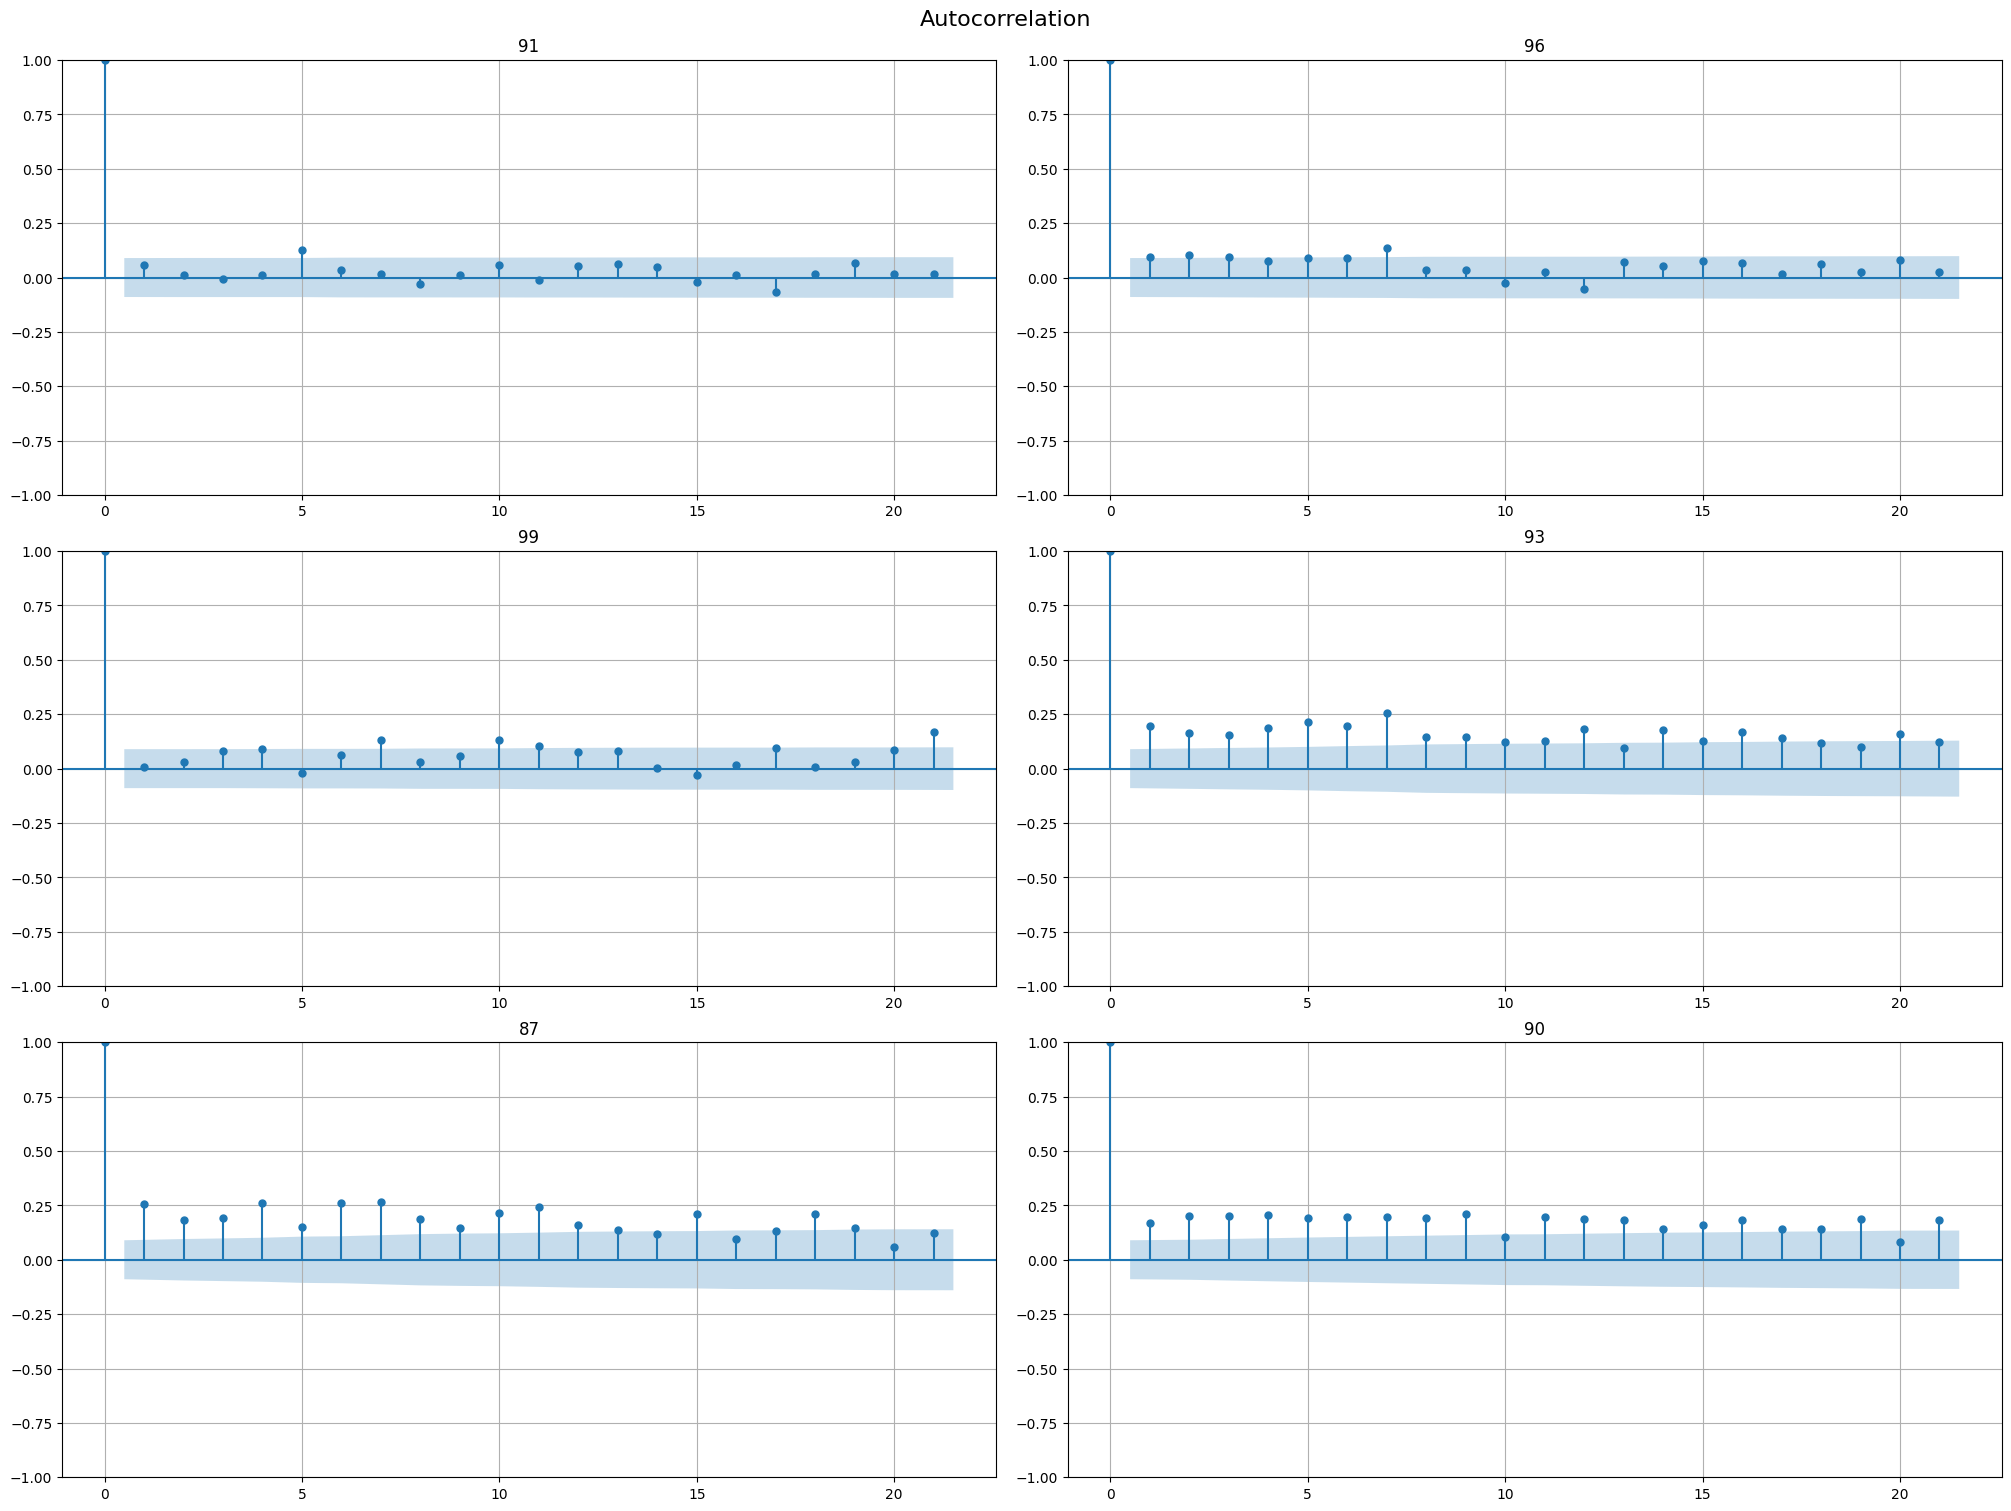

In [159]:
acf_plot(ts, lags=21, n_segments=6)

анализ лагов был ранее, а вот дополнительно имеет смысл добавить метки праздничных дней и отметку дня месяца и для недели. В праздники люди много тратят, значит и много снимают денег в банкоматах (возможно стоит брать предпраздничные дни, но как их отметить с каким периодом сложно сказать (может стоит сделать свой календарь, под конкретную задачу и он будет сильно помогать моделям обучаться)). В месяце есть несколько дат, когда люди получают зарплату и многие ее снимают в наличку (например 5, 15, 20, 30 числа или прилегающие дни, если это выходные). На неделе есть выходные, когда семейные люди едут куда-то развлекать дедишек или сами развлекаться, так что и это может иметь значение.

In [13]:
lags = [7, 15]
arima_transform = [
    TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=14),
    STLTransform(in_column="target", period=7, model="arima"),
    LagTransform(in_column="target", lags=lags, out_column='Lag'),
    DateFlagsTransform(day_number_in_week=True, day_number_in_month=True, season_number=True, out_column=''),
    HolidayTransform(iso_code='RUS', mode='binary', out_column='is_holiday')
]
ts_ARIMA = TSDataset(df=df, freq="D")
ts_ARIMA.fit_transform(arima_transform)
ts_ARIMA.tail(10)

segment            100                                                       \
feature         Lag_15       Lag_7 _day_number_in_month _day_number_in_week   
timestamp                                                                     
2018-09-21  447.042006  224.326047                   21                   4   
2018-09-22 -525.637095    2.748113                   22                   5   
2018-09-23 -134.512504  210.421128                   23                   6   
2018-09-24 -449.594121 -362.934150                   24                   0   
2018-09-25  166.051341  391.454709                   25                   1   
2018-09-26  -83.227818 -410.376818                   26                   2   
2018-09-27  400.713751  347.220639                   27                   3   
2018-09-28 -394.736698  -65.570771                   28                   4   
2018-09-29  224.326047 -262.913391                   29                   5   
2018-09-30    2.748113  236.186666                   30                   6   

segment                                                              101  \
feature    _is_weekend _season_number is_holiday      target      Lag_15   
timestamp                                                                  
2018-09-21       False              4          0  -65.570771 -108.349964   
2018-09-22        True              4          0 -262.913391  375.538587   
2018-09-23        True              4          0  236.186666  233.894937   
2018-09-24       False              4          0  277.028715  253.206313   
2018-09-25       False              4          0 -366.199409 -327.070395   
2018-09-26       False              4          0  100.818358   12.584972   
2018-09-27       False              4          0 -155.134931  249.546196   
2018-09-28       False              4          0   47.763611 -640.346729   
2018-09-29        True              4          0  228.662622  314.666801   
2018-09-30        True              4          0 -209.239087   60.238109   

segment                 ...         98                      99              \
feature          Lag_7  ... is_holiday      target      Lag_15       Lag_7   
timestamp               ...                                                  
2018-09-21  314.666801  ...          0 -174.535217 -389.699911 -313.924088   
2018-09-22   60.238109  ...          0 -159.490432  953.688416  255.691408   
2018-09-23 -337.931940  ...          0  -11.182481 -361.026156 -119.468169   
2018-09-24  241.913988  ...          0  267.364845  367.570866 -424.113118   
2018-09-25  149.586419  ...          0  -19.794394  -21.778196 -384.084409   
2018-09-26  -84.452118  ...          0  -40.260740  275.820517  360.768510   
2018-09-27  785.545415  ...          0 -178.744401 -350.899385  392.915744   
2018-09-28 -394.735275  ...          0  -84.906853 -140.713417  389.613078   
2018-09-29 -442.868820  ...          0  182.286046 -313.924088 -592.816426   
2018-09-30 -224.122059  ...          0  113.120344  255.691408  -45.631052   

segment                                                          \
feature    _day_number_in_month _day_number_in_week _is_weekend   
timestamp                                                         
2018-09-21                   21                   4       False   
2018-09-22                   22                   5        True   
2018-09-23                   23                   6        True   
2018-09-24                   24                   0       False   
2018-09-25                   25                   1       False   
2018-09-26                   26                   2       False   
2018-09-27                   27                   3       False   
2018-09-28                   28                   4       False   
2018-09-29                   29                   5        True   
2018-09-30                   30                   6        True   

segment                                           
feature    _season_number is_holiday      tar

In [28]:
catboost_transform = [
    TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=14),
    DateFlagsTransform(day_number_in_week=True, day_number_in_month=True, season_number=True, out_column=''),
    HolidayTransform(iso_code='RUS', mode='binary', out_column='is_holiday'),
    STLTransform(in_column="target", period=7)
]
ts_CatBoost = TSDataset(df=df, freq="D")
ts_CatBoost.fit_transform(catboost_transform)
ts_CatBoost.tail()

segment                     100                                  \
feature    _day_number_in_month _day_number_in_week _is_weekend   
timestamp                                                         
2018-09-26                   26                   2       False   
2018-09-27                   27                   3       False   
2018-09-28                   28                   4       False   
2018-09-29                   29                   5        True   
2018-09-30                   30                   6        True   

segment                                                           101  \
feature    _season_number is_holiday      target _day_number_in_month   
timestamp                                                               
2018-09-26              4          0  100.818358                   26   
2018-09-27              4          0 -155.134931                   27   
2018-09-28              4          0   47.763611                   28   
2018-09-29              4          0  228.662622                   29   
2018-09-30              4          0 -209.239087                   30   

segment                                                    ...          98  \
feature    _day_number_in_week _is_weekend _season_number  ... _is_weekend   
timestamp                                                  ...               
2018-09-26                   2       False              4  ...       False   
2018-09-27                   3       False              4  ...       False   
2018-09-28                   4       False              4  ...       False   
2018-09-29                   5        True              4  ...        True   
2018-09-30                   6        True              4  ...        True   

segment                                                            99  \
feature    _season_number is_holiday      target _day_number_in_month   
timestamp                                                               
2018-09-26              4          0  -40.260740                   26   
2018-09-27              4          0 -178.744401                   27   
2018-09-28              4          0  -84.906853                   28   
2018-09-29              4          0  182.286046                   29   
2018-09-30              4          0  113.120344                   30   

segment                                                               \
feature    _day_number_in_week _is_weekend _season_number is_holiday   
timestamp                                                              
2018-09-26                   2       False              4          0   
2018-09-27                   3       False              4          0   
2018-09-28                   4       False              4          0   
2018-09-29                   5        True              4          0   
2018-09-30                   6        True              4          0   

segment                 
feature         target  
timestamp               
2018-09-26  -10.742526  
2018-09-27 -144.522247  
2018-09-28 -297.881110  
2018-09-29  412.798927  
2018-09-30   70.346376  

[5 rows x 120 columns]

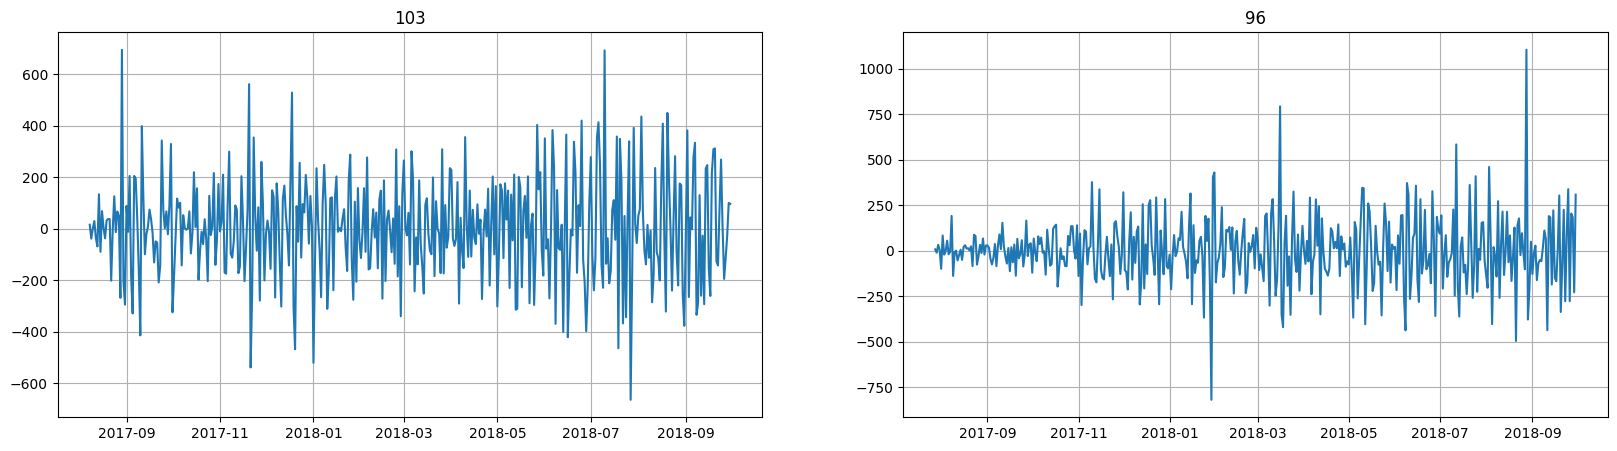

In [29]:
ts_CatBoost.plot(n_segments=2)

In [30]:
metrics = [MAE()]

In [31]:
pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(iterations=100),
    transforms=catboost_transform,
    horizon=HORIZON
)

catboost_multi_metrics, catboost_multi_forecast, _ = pipeline.backtest(ts=ts, metrics=metrics, n_folds=3, aggregate_metrics=True, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [32]:
pipeline = Pipeline(
    model=CatBoostPerSegmentModel(iterations=100),
    transforms=catboost_transform,
    horizon=HORIZON
)

catboost_per_metrics, catboost_per_forecast, _ = pipeline.backtest(ts=ts, metrics=metrics, n_folds=3, aggregate_metrics=True, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    8.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [74]:
pipeline = Pipeline(
    model=AutoARIMAModel(),
    transforms=arima_transform,
    horizon=HORIZON
)

arima_metrics, arima_forecast, _ = pipeline.backtest(ts=ts, metrics=metrics, n_folds=3, aggregate_metrics=True, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   48.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [33]:
arima_metrics = arima_metrics.set_index("segment").add_suffix("_arima")
catboost_multi_metrics = catboost_multi_metrics.set_index("segment").add_suffix("_cat_multi")
catboost_per_metrics = catboost_per_metrics.set_index("segment").add_suffix("_cat_per")

In [34]:
all_metrics_with_arima_cat = pd.concat([all_metrics, arima_metrics, catboost_multi_metrics, catboost_per_metrics], axis=1)

In [35]:
all_metrics_with_arima_cat

MAE_ahp  MAE_atm_level   MAE_arima  MAE_cat_multi  MAE_cat_per
segment                                                                   
100      272.607997     285.911349  313.153885     312.450184   305.732268
101      315.727960     309.135288  383.597296     405.468821   425.608186
102      305.109312     226.543800  318.196017     394.107102   383.455809
103      283.490997     267.398657  265.235559     306.658135   301.761377
104      287.196083     250.512477  304.044440     354.010657   358.402004
105      295.137328     277.918351  250.140227     271.391815   272.422157
106       69.737640      91.443786   92.982536      98.967396   108.395194
74       768.951230     598.989726  832.424125     813.155501   806.478833
85       323.883071     266.777040  287.891100     289.712147   270.875410
86       190.572418     172.814477  213.896573     183.456130   194.152465
87       457.364005     336.371277  399.494747     450.819870   422.948032
88       413.892846     334.596857  343.238772     384.073518   358.447219
90       205.291491     210.418686  265.746412     256.642475   275.407893
91       332.660638     310.275370  329.269396     355.048326   390.205581
93       331.348148     347.576921  498.905391     461.989427   470.967326
94       196.433847     190.592950  270.297665     275.758736   264.965959
96       182.638740     175.624062  256.715117     235.112722   250.640603
97       359.059973     280.343662  473.029696     500.189433   495.994990
98       228.150723     238.778289  282.562079     275.975928   288.175617
99       376.494457     338.958425  361.833139     347.425460   359.890798

In [36]:
all_metrics_with_arima_cat.mean()

MAE_ahp          309.787445
MAE_atm_level    275.549072
MAE_arima        337.132709
MAE_cat_multi    348.620689
MAE_cat_per      350.246386
dtype: float64

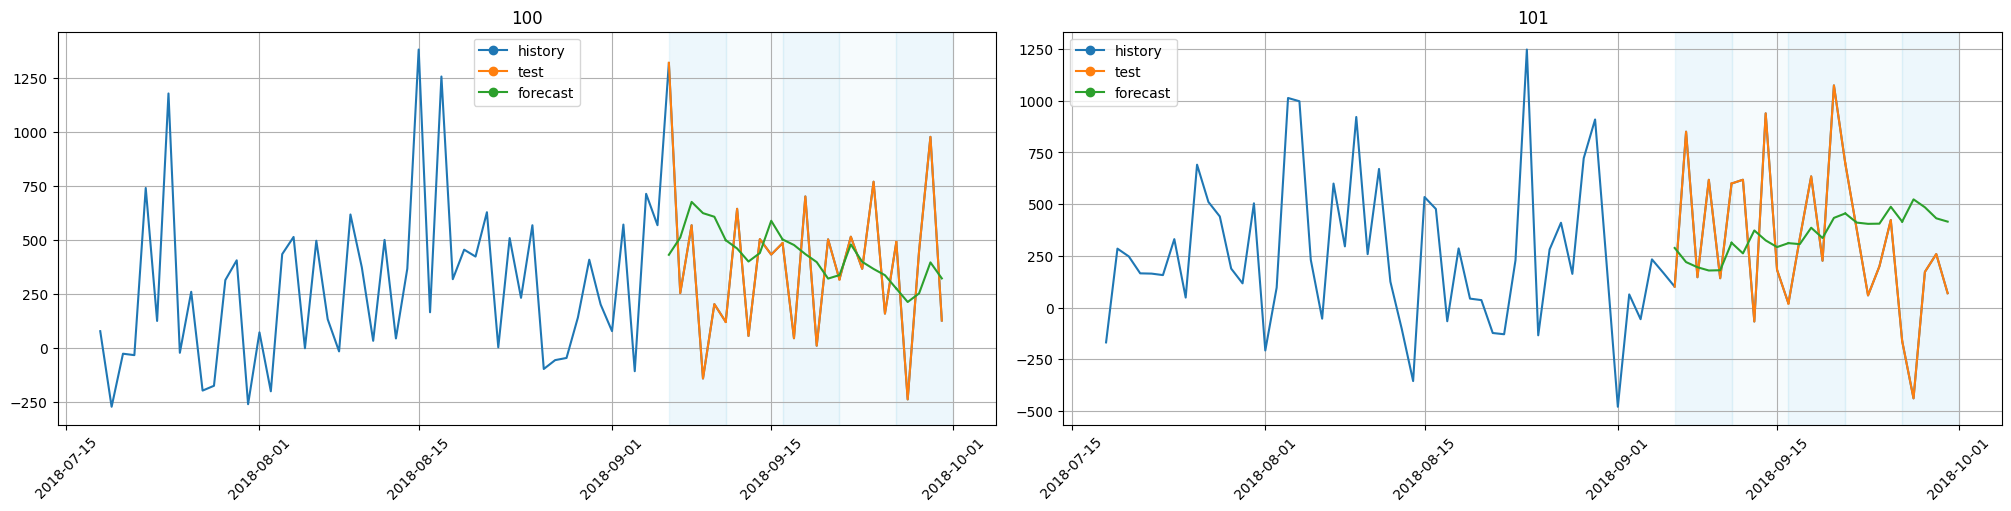

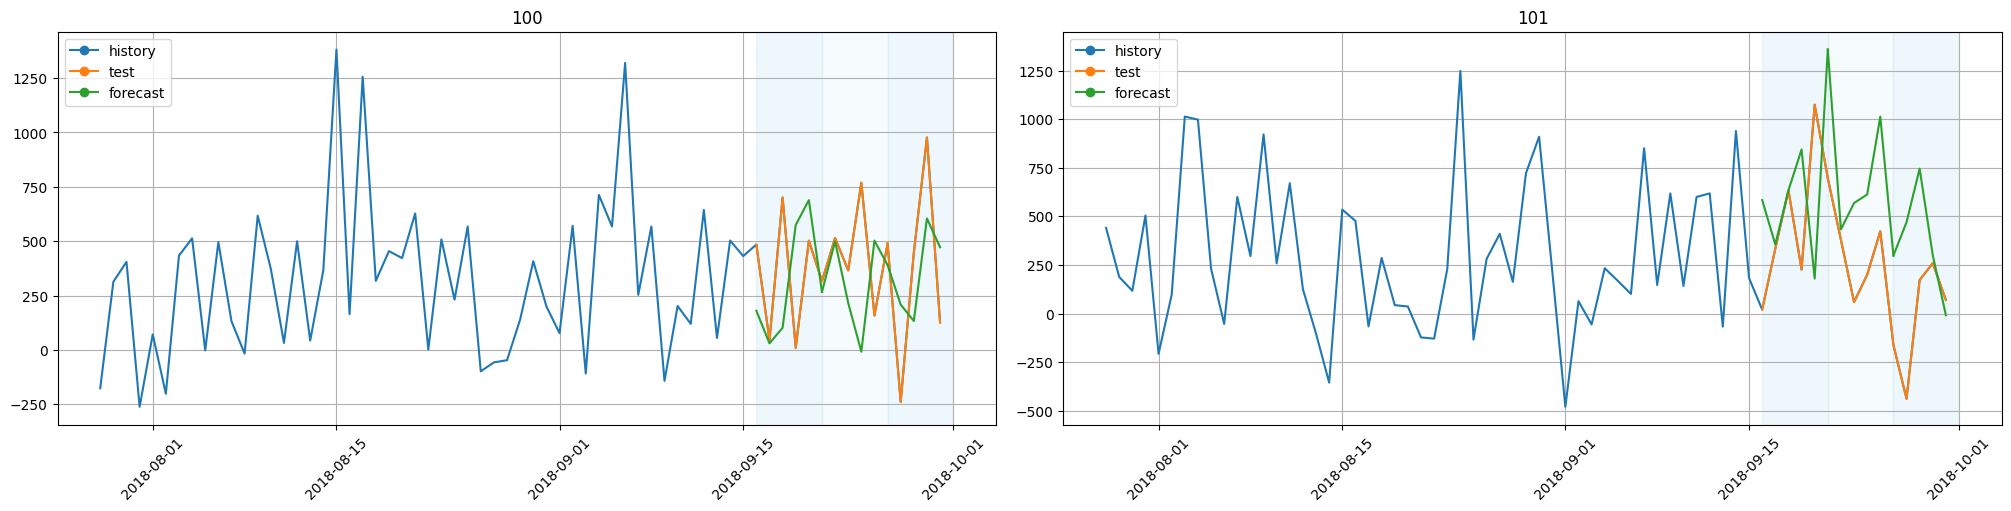

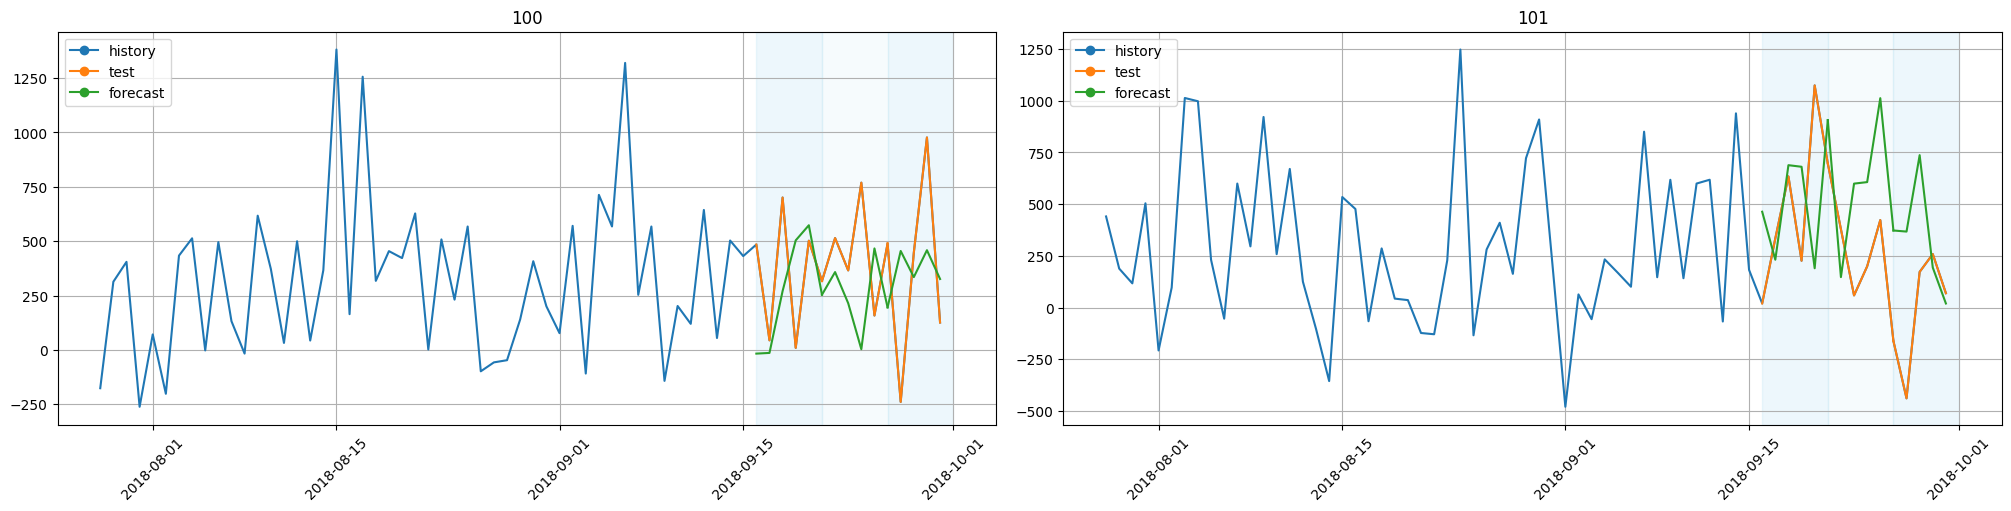

In [75]:
plot_backtest(forecast_df=ahp_forecast-2000, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=forecast_df1, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=catboost_multi_forecast, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=catboost_per_forecast, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=arima_forecast, ts=ts, history_len=50, segments=['100', '101'])#'all')

### Задание 6. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [44]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [61]:
arima_transform = [
    TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=14),
    STLTransform(in_column="target", period=7, model="arima"),
    #LagTransform(in_column="target", lags=lags, out_column='Lag'),
    #DateFlagsTransform(day_number_in_week=True, day_number_in_month=True, season_number=True, out_column=''),
    #HolidayTransform(iso_code='RUS', mode='binary', out_column='is_holiday')
]

In [54]:
catboost_transform = [
    TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=14),
    DateFlagsTransform(day_number_in_week=True, day_number_in_month=True, season_number=True, out_column=''),
    HolidayTransform(iso_code='RUS', mode='binary', out_column='is_holiday'),
    STLTransform(in_column="target", period=7)
]

In [56]:
metrics = [MAE()]

In [67]:
ar_pipeline = AutoRegressivePipeline(
    model=CatBoostMultiSegmentModel(iterations=100),
    transforms=catboost_transform,
    horizon=HORIZON
)

catboost_multi_ar_metrics, catboost_multi_ar_forecast, _ = ar_pipeline.backtest(ts=ts, metrics=metrics, n_folds=3, aggregate_metrics=True, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   20.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   31.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   31.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [68]:
ar_pipeline = AutoRegressivePipeline(
    model=CatBoostPerSegmentModel(iterations=100),
    transforms=catboost_transform,
    horizon=HORIZON
)

catboost_per_ar_metrics, catboost_per_ar_forecast, _ = ar_pipeline.backtest(ts=ts, metrics=metrics, n_folds=3, aggregate_metrics=True, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   20.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   31.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   31.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [69]:
ar_pipeline = AutoRegressivePipeline(
    model=AutoARIMAModel(),
    transforms=arima_transform,
    horizon=HORIZON
)

arima_ar_metrics, arima_ar_forecast, _ = ar_pipeline.backtest(ts=ts, metrics=metrics, n_folds=3, aggregate_metrics=True, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   52.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.6min
/Users/nikitaevseev/anaconda3/envs/etna_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/Users/nikitaevseev/anaconda3/envs/etna_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/Users/nikitaevseev/anaconda3/envs/etna_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to beg

In [70]:
arima_ar_metrics = arima_ar_metrics.set_index("segment").add_suffix("_arima_ar")
catboost_multi_ar_metrics = catboost_multi_ar_metrics.set_index("segment").add_suffix("_cat_multi_ar")
catboost_per_ar_metrics = catboost_per_ar_metrics.set_index("segment").add_suffix("_cat_per_ar")

In [71]:
all_metrics_with_arima_cat_ar = pd.concat([all_metrics_with_arima_cat, arima_ar_metrics, catboost_multi_ar_metrics, catboost_per_ar_metrics], axis=1)

In [72]:
all_metrics_with_arima_cat_ar

MAE_ahp  MAE_atm_level   MAE_arima  MAE_cat_multi  MAE_cat_per  \
segment                                                                      
100      272.607997     285.911349  313.153885     312.450184   305.732268   
101      315.727960     309.135288  383.597296     405.468821   425.608186   
102      305.109312     226.543800  318.196017     394.107102   383.455809   
103      283.490997     267.398657  265.235559     306.658135   301.761377   
104      287.196083     250.512477  304.044440     354.010657   358.402004   
105      295.137328     277.918351  250.140227     271.391815   272.422157   
106       69.737640      91.443786   92.982536      98.967396   108.395194   
74       768.951230     598.989726  832.424125     813.155501   806.478833   
85       323.883071     266.777040  287.891100     289.712147   270.875410   
86       190.572418     172.814477  213.896573     183.456130   194.152465   
87       457.364005     336.371277  399.494747     450.819870   422.948032   
88       413.892846     334.596857  343.238772     384.073518   358.447219   
90       205.291491     210.418686  265.746412     256.642475   275.407893   
91       332.660638     310.275370  329.269396     355.048326   390.205581   
93       331.348148     347.576921  498.905391     461.989427   470.967326   
94       196.433847     190.592950  270.297665     275.758736   264.965959   
96       182.638740     175.624062  256.715117     235.112722   250.640603   
97       359.059973     280.343662  473.029696     500.189433   495.994990   
98       228.150723     238.778289  282.562079     275.975928   288.175617   
99       376.494457     338.958425  361.833139     347.425460   359.890798   

         MAE_arima_ar  MAE_cat_multi_ar  MAE_cat_per_ar  
segment                                                  
100        321.284277        312.450184      305.732268  
101        395.810207        405.468821      425.608186  
102        334.986968        394.107102      383.455809  
103        253.684474        306.658135      301.761377  
104        373.708928        354.010657      358.402004  
105        222.704658        271.391815      272.422157  
106         93.563219         98.967396      108.395194  
74         810.657049        813.155501      806.478833  
85         275.295518        289.712147      270.875410  
86         183.476319        183.456130      194.152465  
87         414.283815        450.819870      422.948032  
88         339.376581        384.073518      358.447219  
90         278.816948        256.642475      275.407893  
91         318.245816        355.048326      390.205581  
93         404.224347        461.989427      470.967326  
94         261.850567        275.758736      264.965959  
96         252.515735        235.112722      250.640603  
97         476.934488        500.189433      495.994990  
98         282.177986        275.975928      288.175617  
99         376.641178        347.425460      359.890798

In [73]:
all_metrics_with_arima_cat_ar.mean()

MAE_ahp             309.787445
MAE_atm_level       275.549072
MAE_arima           337.132709
MAE_cat_multi       348.620689
MAE_cat_per         350.246386
MAE_arima_ar        333.511954
MAE_cat_multi_ar    348.620689
MAE_cat_per_ar      350.246386
dtype: float64

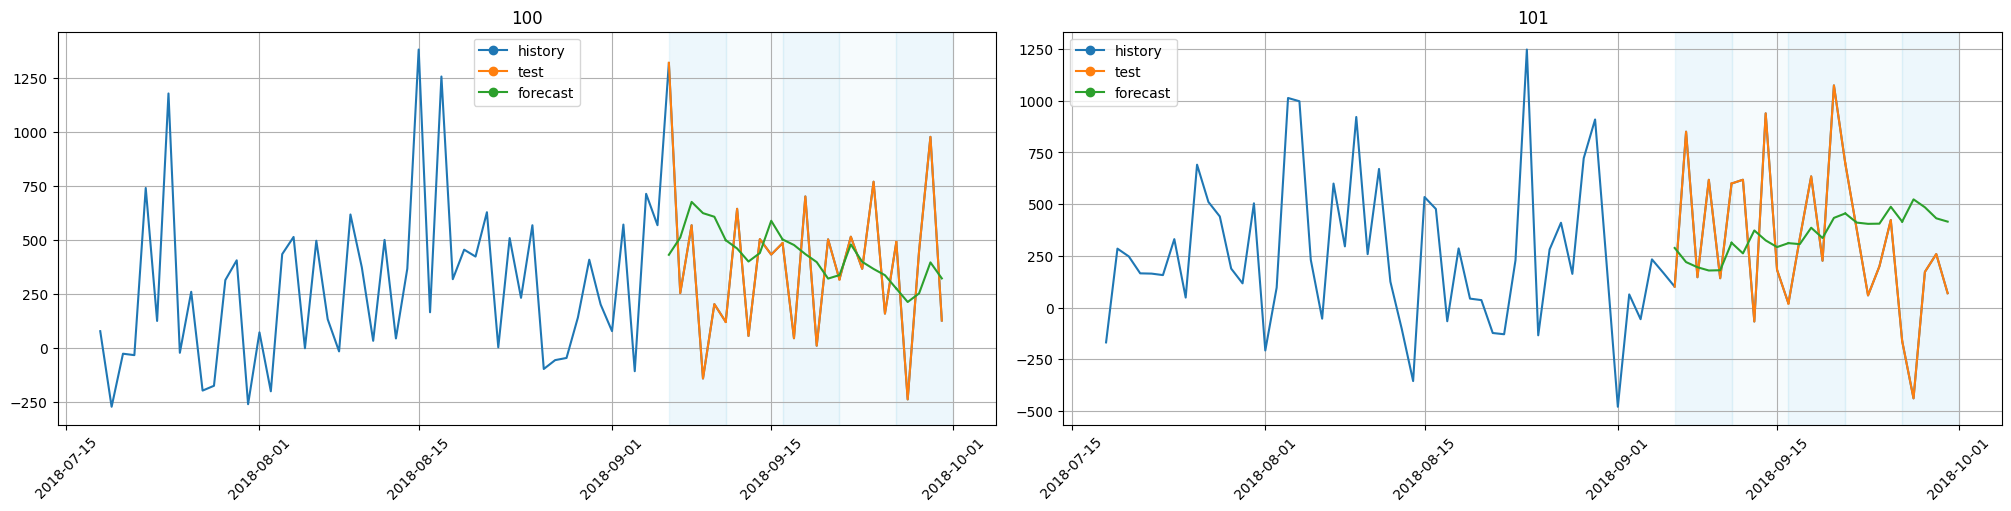

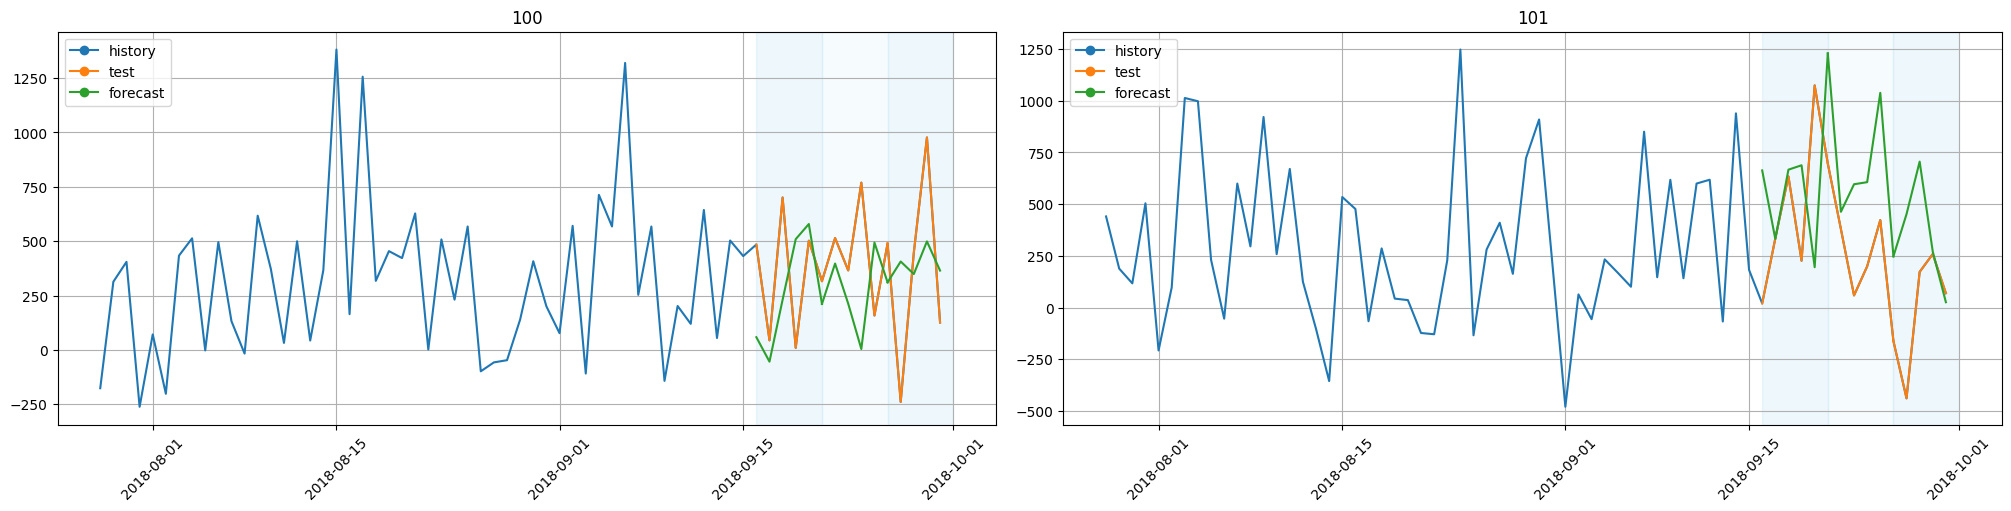

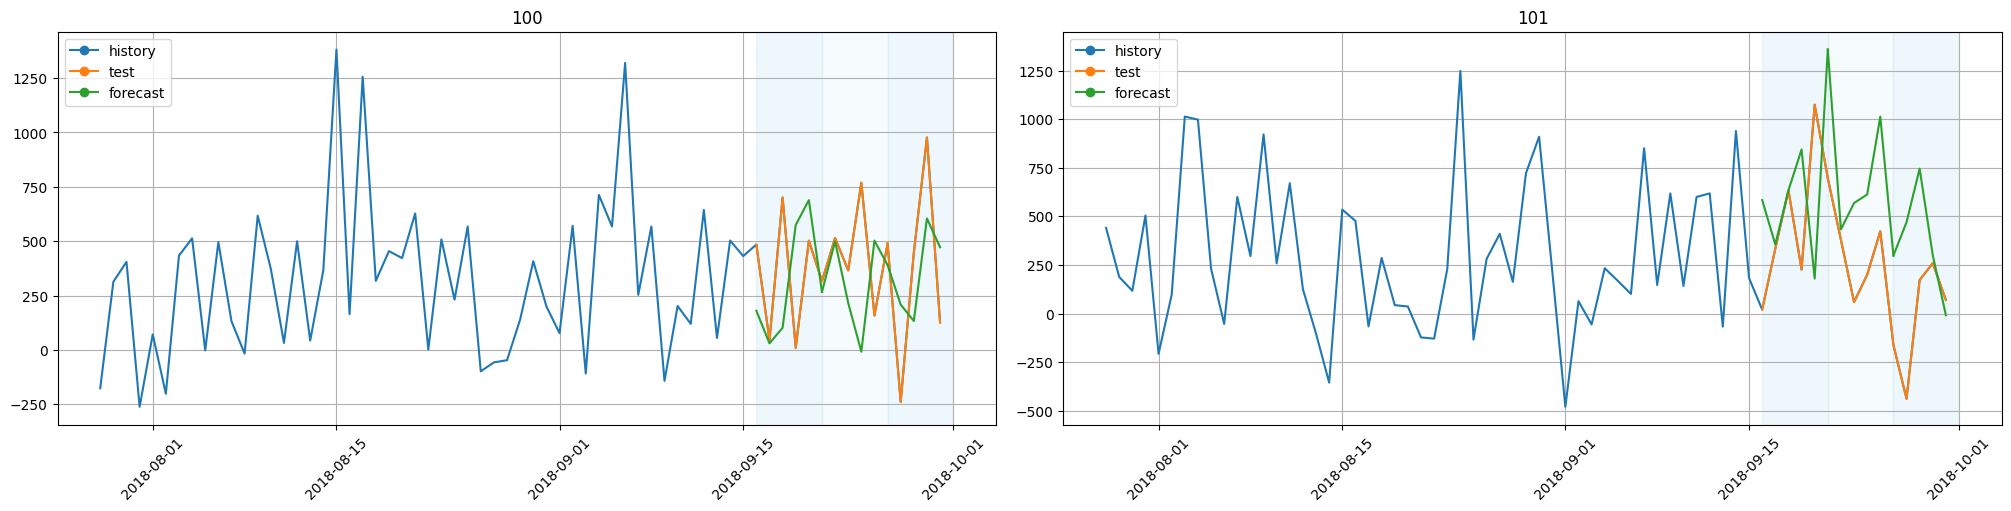

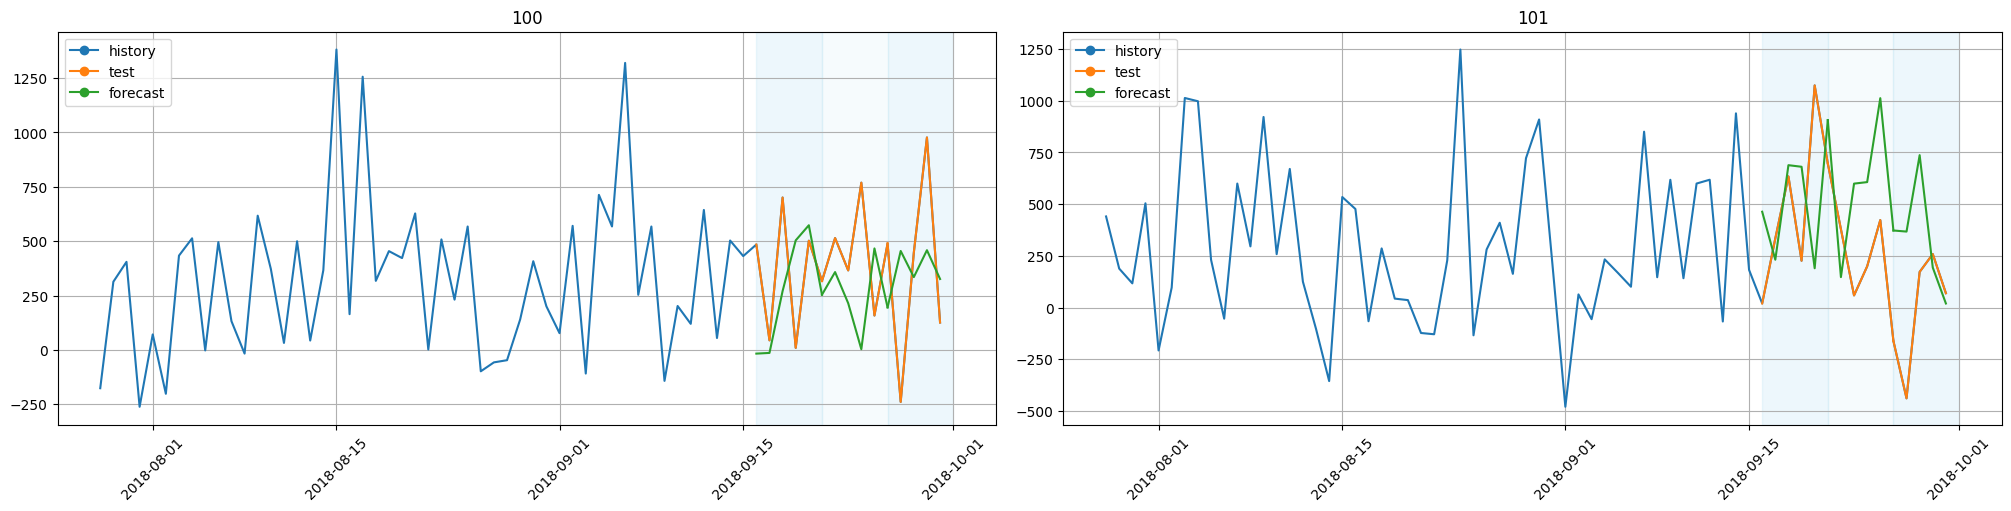

In [91]:
plot_backtest(forecast_df=forecast_df1, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=ahp_forecast-2000, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=catboost_multi_ar_forecast, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=catboost_per_ar_forecast, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=arima_ar_forecast, ts=ts, history_len=50, segments=['100', '101'])#'all')

без особых изменений

### Задание 7. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [26]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [84]:
voting_ensemble = VotingEnsemble(
    pipelines=[
        Pipeline(
            model=CatBoostMultiSegmentModel(iterations=100),
            transforms=catboost_transform,
            horizon=HORIZON
        ), 
        Pipeline(
            model=CatBoostPerSegmentModel(iterations=100),
            transforms=catboost_transform,
            horizon=HORIZON
        ), 
        Pipeline(
            model=AutoARIMAModel(),
            transforms=arima_transform,
            horizon=HORIZON
        )
    ]
)
voting_ensemble_metrics, voting_ensemble_forecast, _ = voting_ensemble.backtest(ts=ts, metrics=metrics, n_folds=3, aggregate_metrics=True, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   55.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   55.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   51.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   51.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.8min
[Parallel(n_jobs=1)]: Do

In [85]:
stacking_ensemble = StackingEnsemble(
    pipelines=[
        Pipeline(
            model=CatBoostMultiSegmentModel(iterations=100),
            transforms=catboost_transform,
            horizon=HORIZON
        ), 
        Pipeline(
            model=CatBoostPerSegmentModel(iterations=100),
            transforms=catboost_transform,
            horizon=HORIZON
        ), 
        Pipeline(
            model=AutoARIMAModel(),
            transforms=arima_transform,
            horizon=HORIZON
        )
    ]
)
stacking_ensemble_metrics, stacking_ensemble_forecast, _ = stacking_ensemble.backtest(ts=ts, metrics=metrics, n_folds=3, aggregate_metrics=True, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    9.7s
[Parallel(n_jobs=1)]: Do

In [86]:
voting_ensemble_metrics = voting_ensemble_metrics.set_index("segment").add_suffix("_voting_ensemble")
stacking_ensemble_metrics = stacking_ensemble_metrics.set_index("segment").add_suffix("_stacking_ensemble")

In [87]:
all_metrics_with_arima_cat_ar_ensemble = pd.concat([all_metrics_with_arima_cat_ar, voting_ensemble_metrics, stacking_ensemble_metrics], axis=1)

In [88]:
all_metrics_with_arima_cat_ar_ensemble

MAE_ahp  MAE_atm_level   MAE_arima  MAE_cat_multi  MAE_cat_per  \
segment                                                                      
100      272.607997     285.911349  313.153885     312.450184   305.732268   
101      315.727960     309.135288  383.597296     405.468821   425.608186   
102      305.109312     226.543800  318.196017     394.107102   383.455809   
103      283.490997     267.398657  265.235559     306.658135   301.761377   
104      287.196083     250.512477  304.044440     354.010657   358.402004   
105      295.137328     277.918351  250.140227     271.391815   272.422157   
106       69.737640      91.443786   92.982536      98.967396   108.395194   
74       768.951230     598.989726  832.424125     813.155501   806.478833   
85       323.883071     266.777040  287.891100     289.712147   270.875410   
86       190.572418     172.814477  213.896573     183.456130   194.152465   
87       457.364005     336.371277  399.494747     450.819870   422.948032   
88       413.892846     334.596857  343.238772     384.073518   358.447219   
90       205.291491     210.418686  265.746412     256.642475   275.407893   
91       332.660638     310.275370  329.269396     355.048326   390.205581   
93       331.348148     347.576921  498.905391     461.989427   470.967326   
94       196.433847     190.592950  270.297665     275.758736   264.965959   
96       182.638740     175.624062  256.715117     235.112722   250.640603   
97       359.059973     280.343662  473.029696     500.189433   495.994990   
98       228.150723     238.778289  282.562079     275.975928   288.175617   
99       376.494457     338.958425  361.833139     347.425460   359.890798   

         MAE_arima_ar  MAE_cat_multi_ar  MAE_cat_per_ar  MAE_voting_ensemble  \
segment                                                                        
100        321.284277        312.450184      305.732268           313.155576   
101        395.810207        405.468821      425.608186           399.568545   
102        334.986968        394.107102      383.455809           369.049440   
103        253.684474        306.658135      301.761377           284.081674   
104        373.708928        354.010657      358.402004           362.040529   
105        222.704658        271.391815      272.422157           251.299599   
106         93.563219         98.967396      108.395194            98.047371   
74         810.657049        813.155501      806.478833           810.097128   
85         275.295518        289.712147      270.875410           273.659956   
86         183.476319        183.456130      194.152465           184.459034   
87         414.283815        450.819870      422.948032           426.494083   
88         339.376581        384.073518      358.447219           360.632439   
90         278.816948        256.642475      275.407893           266.322095   
91         318.245816        355.048326      390.205581           350.312476   
93         404.224347        461.989427      470.967326           444.239450   
94         261.850567        275.758736      264.965959           267.438670   
96         252.515735        235.112722      250.640603           246.089687   
97         476.934488        500.189433      495.994990           491.039637   
98         282.177986        275.975928      288.175617           272.216368   
99         376.641178        347.425460      359.890798           361.319145   

         MAE_stacking_ensemble  
segment                         
100                 263.218020  
101                 307.595045  
102                 225.182666  
103                 275.887727  
104                 288.582008  
105                 246.492216  
106                 215.227709  
74                  803.303096  
85                  225.973731  
86                  170.874926  
87                  290.280498  
88                  174.168421  
90                  202.098040  
91                  203.178229  
93    

In [89]:
all_metrics_with_arima_cat_ar_ensemble.mean()

MAE_ahp                  309.787445
MAE_atm_level            275.549072
MAE_arima                337.132709
MAE_cat_multi            348.620689
MAE_cat_per              350.246386
MAE_arima_ar             333.511954
MAE_cat_multi_ar         348.620689
MAE_cat_per_ar           350.246386
MAE_voting_ensemble      341.578145
MAE_stacking_ensemble    283.307653
dtype: float64

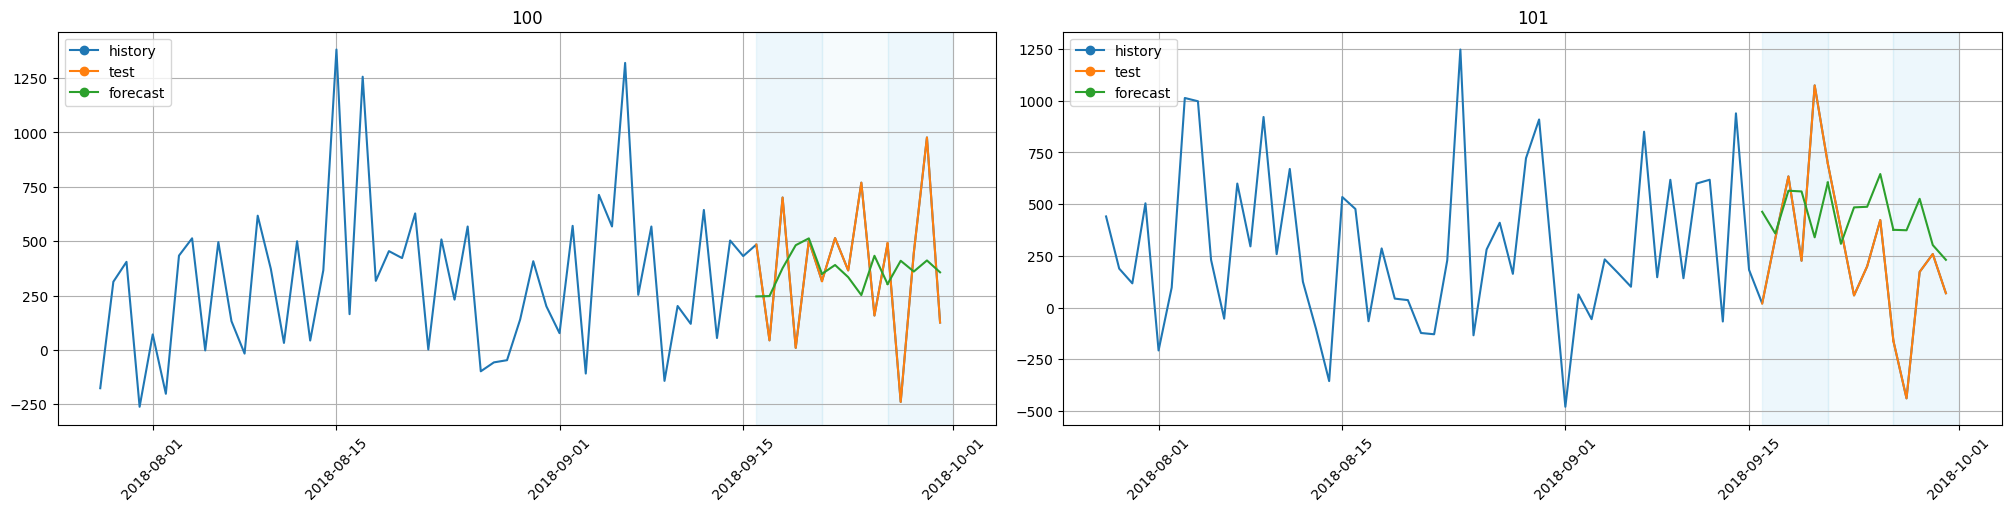

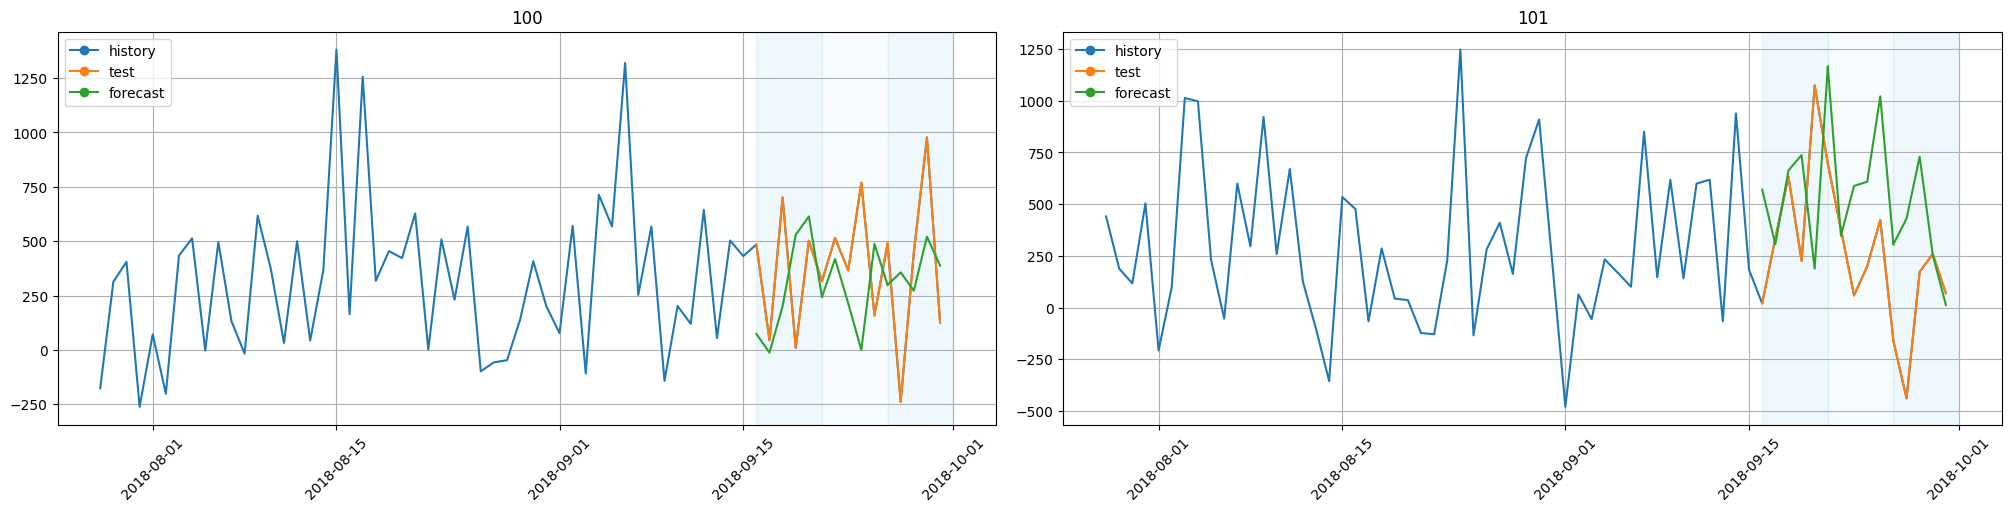

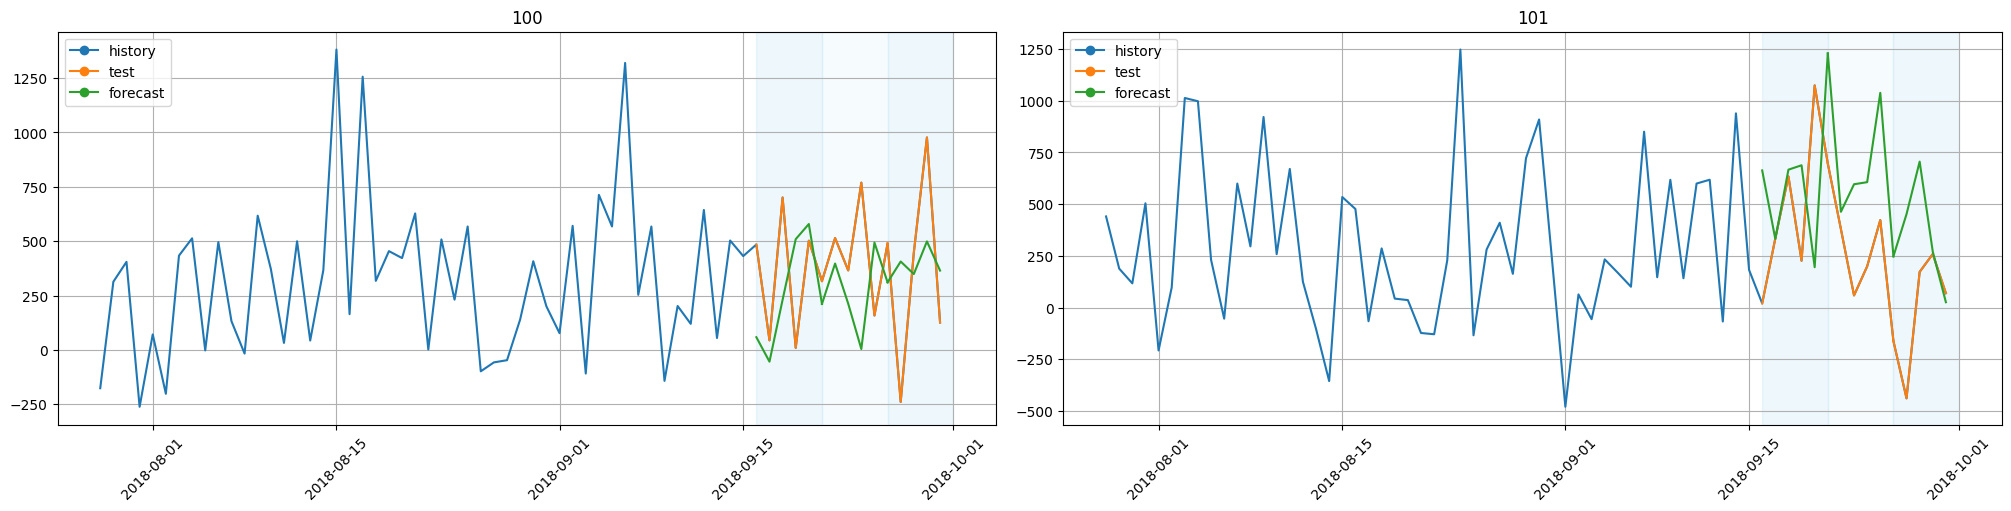

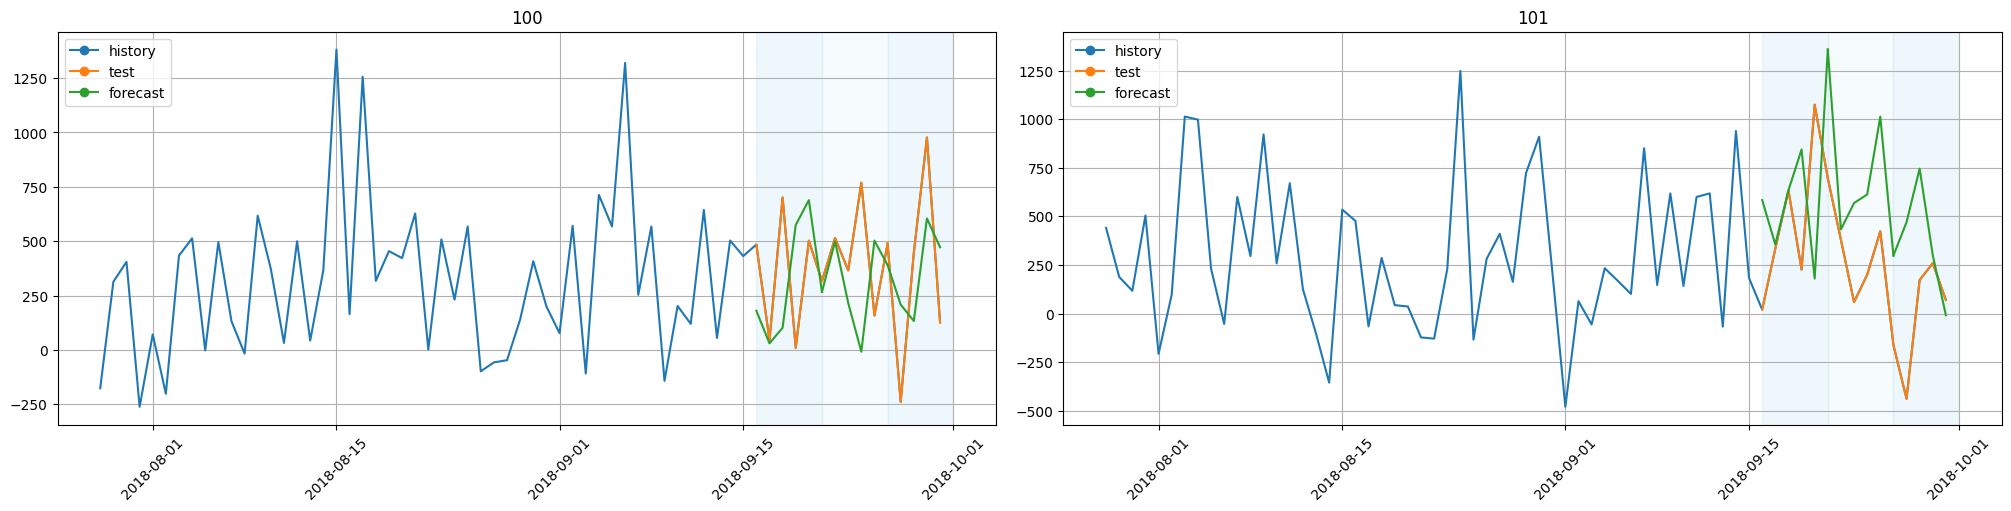

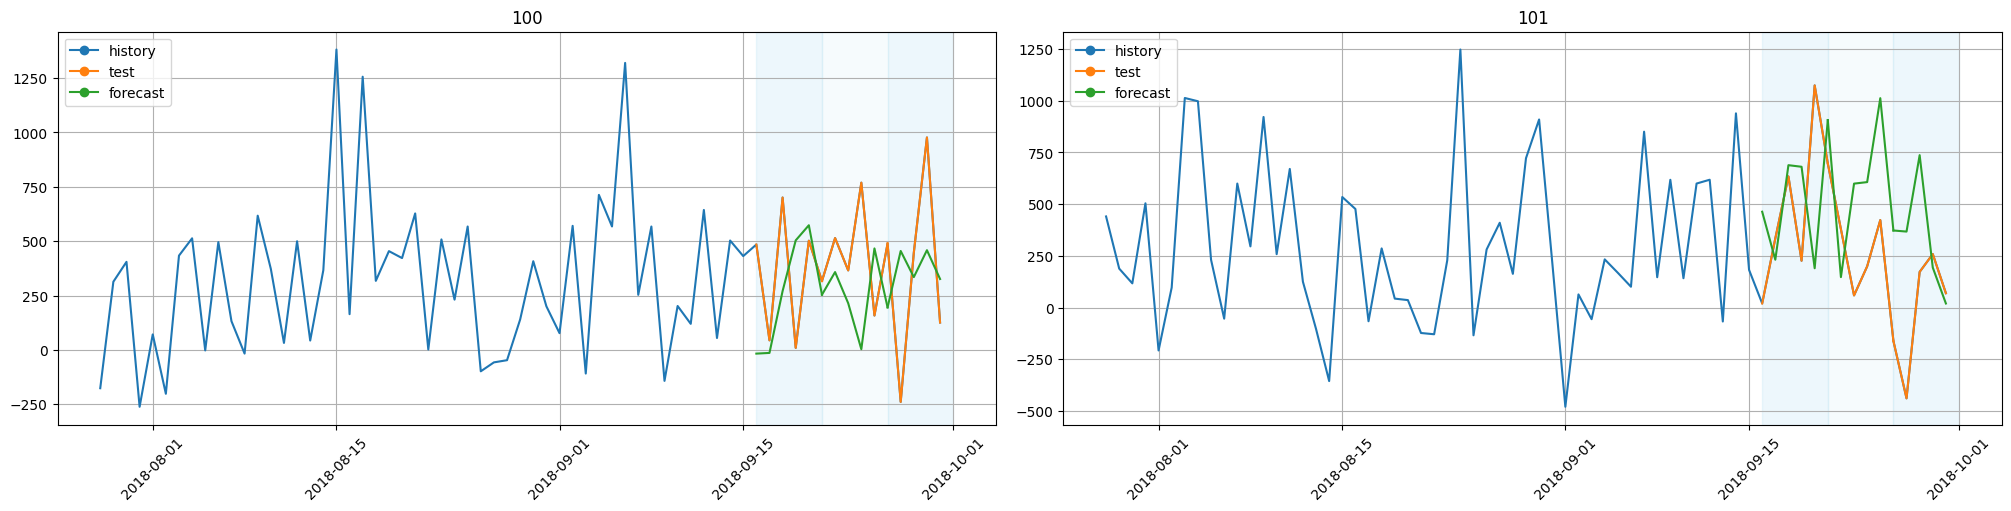

In [90]:
plot_backtest(forecast_df=stacking_ensemble_forecast, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=voting_ensemble_forecast, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=catboost_multi_forecast, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=catboost_per_forecast, ts=ts, history_len=50, segments=['100', '101'])#'all')
plot_backtest(forecast_df=arima_forecast, ts=ts, history_len=50, segments=['100', '101'])#'all')

Стакинг приводит к той же проблеме, что и у профета, они достаточно усреднены, поэтому дают хорошие значения метрик, но по факту не отражают особенности ряда

### Задание 8*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#